# Моделирование: Предсказание оттока клиентов

В этом ноутбуке мы:
1. Загрузим подготовленные данные (базовый и расширенный датасеты)
2. Применим **2 типа кодирования категориальных признаков**:
   - **LabelEncoder** - для tree-based и бустинговых моделей
   - **OneHotEncoder (drop_first=True)** - для линейных моделей (избегаем dummy variable trap)
3. Применим 2 стратегии:
   - **Простой Train-Test Split**
   - **SMOTENC для балансировки классов** (только для tree-based моделей)
4. Сравним модели на двух версиях данных:
   - **Базовый датасет** (исходные признаки)
   - **Расширенный датасет** (с engineered features)
5. Выберем лучшую модель

## Структура эксперимента:
- **Линейные модели**: Logistic Regression, SVM, KNN, Ridge, Lasso, LDA → используют **OneHotEncoder**
- **Tree-based модели**: Decision Tree, Random Forest, Naive Bayes → используют **LabelEncoder**
- **Бустинговые модели**: XGBoost, LightGBM, CatBoost, AdaBoost → используют **LabelEncoder**

In [428]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn для моделирования
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Метрики
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# SMOTENC для балансировки классов (для mixed данных с категориальными признаками)
from imblearn.over_sampling import SMOTENC

# Бустинговые алгоритмы
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Загрузка данных

In [429]:
df_base = pd.read_csv('data/processed/base_dataset.csv')
df_enhanced = pd.read_csv('data/processed/enhanced_dataset.csv')


print("ЗАГРУЖЕННЫЕ ДАННЫЕ")

print(f"\nБазовая выборка: {df_base.shape}")
print(f"Расширенная выборка: {df_enhanced.shape}")

print(f"\nРаспределение целевой переменной:")
print(df_enhanced['Churn'].value_counts())
print(f"\nБаланс классов:")
churn_dist = df_enhanced['Churn'].value_counts(normalize=True) * 100
print(f"  No:  {churn_dist['No']:.1f}%")
print(f"  Yes: {churn_dist['Yes']:.1f}%")
print(f"\nДисбаланс классов: {churn_dist['No'] / churn_dist['Yes']:.2f}:1")

ЗАГРУЖЕННЫЕ ДАННЫЕ

Базовая выборка: (7043, 20)
Расширенная выборка: (7043, 26)

Распределение целевой переменной:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Баланс классов:
  No:  73.5%
  Yes: 26.5%

Дисбаланс классов: 2.77:1


## 3. Подготовка данных

In [430]:
print("ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА")


df_base_prep = df_base.copy()

# Кодирование целевой переменной
df_base_prep['Churn'] = (df_base_prep['Churn'] == 'Yes').astype(int)

# Разделение на признаки и целевую переменную
X_base = df_base_prep.drop('Churn', axis=1)
y_base = df_base_prep['Churn']

# Кодирование категориальных признаков
categorical_cols_base = X_base.select_dtypes(include='object').columns.tolist() 
categorical_cols_base.append('SeniorCitizen')
print(f"\nКатегориальные признаки ({len(categorical_cols_base)}): {categorical_cols_base}")

# Сохраняем индексы категориальных признаков для SMOTENC
categorical_indices_base = [X_base.columns.get_loc(col) for col in categorical_cols_base]

label_encoders_base = {}
for col in categorical_cols_base:
    le = LabelEncoder()
    X_base[col] = le.fit_transform(X_base[col])
    label_encoders_base[col] = le

print(f"\nБазовый датасет подготовлен:")
print(f"   Размер X: {X_base.shape}")
print(f"   Размер y: {y_base.shape}")
print(f"   Количество признаков: {X_base.shape[1]}")
print(f"   Индексы категориальных признаков: {categorical_indices_base}")

ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА

Категориальные признаки (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Базовый датасет подготовлен:
   Размер X: (7043, 19)
   Размер y: (7043,)
   Количество признаков: 19
   Индексы категориальных признаков: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1]


In [431]:
# Подготовка РАСШИРЕННОГО датасета
print("\nПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА")

df_enhanced_prep = df_enhanced.copy()

# Кодирование целевой переменной
df_enhanced_prep['Churn'] = (df_enhanced_prep['Churn'] == 'Yes').astype(int)

# Разделение на признаки и целевую переменную
X_enhanced = df_enhanced_prep.drop('Churn', axis=1)
y_enhanced = df_enhanced_prep['Churn']

# Кодирование категориальных признаков
categorical_cols_enhanced = X_enhanced.select_dtypes(include='object').columns.tolist()
categorical_cols_enhanced.extend(['SeniorCitizen','has_automatic_payment', 'has_protection_services','is_new_customer'])
print(f"\nКатегориальные признаки ({len(categorical_cols_enhanced)}): {categorical_cols_enhanced}")

# Сохраняем индексы категориальных признаков для SMOTENC
categorical_indices_enhanced = [X_enhanced.columns.get_loc(col) for col in categorical_cols_enhanced]

label_encoders_enhanced = {}
for col in categorical_cols_enhanced:
    le = LabelEncoder()
    X_enhanced[col] = le.fit_transform(X_enhanced[col])
    label_encoders_enhanced[col] = le



ПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА

Категориальные признаки (20): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_category', 'SeniorCitizen', 'has_automatic_payment', 'has_protection_services', 'is_new_customer']


### 3.1. Подготовка данных с OneHotEncoding (для линейных моделей)

Для линейных моделей создадим отдельные версии данных с OneHotEncoding.  
**Важно:** используем `drop_first=True` чтобы избежать мультиколлинеарности (dummy variable trap).

In [432]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

print("ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА С ONEHOTENCODING")

df_base_ohe = df_base.copy()
df_base_ohe['Churn'] = (df_base_ohe['Churn'] == 'Yes').astype(int)

X_base_ohe = df_base_ohe.drop('Churn', axis=1)
y_base_ohe = df_base_ohe['Churn']

# Определяем категориальные и числовые колонки
# Только эти 3 признака действительно числовые (непрерывные)
truly_numerical_cols_base = ['MonthlyCharges', 'TotalCharges','tenure']

# Все остальные колонки - категориальные
categorical_cols_base_ohe = [col for col in X_base_ohe.columns if col not in truly_numerical_cols_base]
numerical_cols_base_ohe = truly_numerical_cols_base

print(f"\nКатегориальные признаки ({len(categorical_cols_base_ohe)}): {categorical_cols_base_ohe}")
print(f"Числовые признаки ({len(numerical_cols_base_ohe)}): {numerical_cols_base_ohe}")

# OneHotEncoder с drop_first=True (избегаем dummy variable trap)
ct_base = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols_base_ohe),
    ('passthrough', 'passthrough', numerical_cols_base_ohe)
])

X_base_ohe_encoded = ct_base.fit_transform(X_base_ohe)

# Получаем названия признаков после OHE
ohe_feature_names = ct_base.named_transformers_['onehot'].get_feature_names_out(categorical_cols_base_ohe)
all_feature_names_base = list(ohe_feature_names) + numerical_cols_base_ohe
X_base_ohe_encoded = pd.DataFrame(X_base_ohe_encoded, columns=all_feature_names_base, index=X_base_ohe.index)

print(f"\nБазовый датасет с OHE подготовлен:")
print(f"   Размер X: {X_base_ohe_encoded.shape}")
print(f"   Было признаков (LabelEncoder): {X_base.shape[1]}")
print(f"   Стало признаков (OneHotEncoder): {X_base_ohe_encoded.shape[1]}")
print(f"   Добавлено признаков: +{X_base_ohe_encoded.shape[1] - X_base.shape[1]}")

ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА С ONEHOTENCODING

Категориальные признаки (16): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Числовые признаки (3): ['MonthlyCharges', 'TotalCharges', 'tenure']

Базовый датасет с OHE подготовлен:
   Размер X: (7043, 30)
   Было признаков (LabelEncoder): 19
   Стало признаков (OneHotEncoder): 30
   Добавлено признаков: +11


In [433]:
# РАСШИРЕННЫЙ датасет с OneHotEncoding
print("\nПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА С ONEHOTENCODING")

df_enhanced_ohe = df_enhanced.copy()
df_enhanced_ohe['Churn'] = (df_enhanced_ohe['Churn'] == 'Yes').astype(int)

X_enhanced_ohe = df_enhanced_ohe.drop('Churn', axis=1)
y_enhanced_ohe = df_enhanced_ohe['Churn']

# Определяем категориальные и числовые колонки
# Только эти 3 признака действительно числовые (непрерывные)
truly_numerical_cols_enhanced = ['tenure', 'MonthlyCharges', 'TotalCharges','charge_per_month_tenure']

# Все остальные колонки - категориальные (включая object и категориальные int)
categorical_cols_enhanced_ohe = [col for col in X_enhanced_ohe.columns if col not in truly_numerical_cols_enhanced]
numerical_cols_enhanced_ohe = truly_numerical_cols_enhanced

print(f"\nКатегориальные признаки ({len(categorical_cols_enhanced_ohe)}): {categorical_cols_enhanced_ohe}")
print(f"Числовые признаки ({len(numerical_cols_enhanced_ohe)}): {numerical_cols_enhanced_ohe}")

# OneHotEncoder с drop_first=True (избегаем dummy variable trap)
ct_enhanced = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols_enhanced_ohe),
    ('passthrough', 'passthrough', numerical_cols_enhanced_ohe)
])

X_enhanced_ohe_encoded = ct_enhanced.fit_transform(X_enhanced_ohe)

# Получаем названия признаков после OHE
ohe_feature_names_enhanced = ct_enhanced.named_transformers_['onehot'].get_feature_names_out(categorical_cols_enhanced_ohe)
all_feature_names_enhanced = list(ohe_feature_names_enhanced) + numerical_cols_enhanced_ohe
X_enhanced_ohe_encoded = pd.DataFrame(X_enhanced_ohe_encoded, columns=all_feature_names_enhanced, index=X_enhanced_ohe.index)

print(f"\nРасширенный датасет с OHE подготовлен:")
print(f"   Размер X: {X_enhanced_ohe_encoded.shape}")
print(f"   Было признаков (LabelEncoder): {X_enhanced.shape[1]}")
print(f"   Стало признаков (OneHotEncoder): {X_enhanced_ohe_encoded.shape[1]}")
print(f"   Добавлено признаков: +{X_enhanced_ohe_encoded.shape[1] - X_enhanced.shape[1]}")



ПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА С ONEHOTENCODING

Категориальные признаки (21): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'total_services', 'has_automatic_payment', 'is_new_customer', 'has_protection_services', 'tenure_category']
Числовые признаки (4): ['tenure', 'MonthlyCharges', 'TotalCharges', 'charge_per_month_tenure']

Расширенный датасет с OHE подготовлен:
   Размер X: (7043, 38)
   Было признаков (LabelEncoder): 25
   Стало признаков (OneHotEncoder): 38
   Добавлено признаков: +13


## Масштабирование признаков

In [434]:
from sklearn.preprocessing import StandardScaler

# StandardScaler для ВСЕХ признаков
scaler = StandardScaler()

# Масштабируем ВСЕ колонки в базовом датасете с OHE
X_base_ohe_scaled = pd.DataFrame(
    scaler.fit_transform(X_base_ohe_encoded),
    columns=X_base_ohe_encoded.columns,
    index=X_base_ohe_encoded.index
)

print("МАСШТАБИРОВАНИЕ БАЗОВОГО ДАТАСЕТА (ВСЕ ПРИЗНАКИ)")
print(f"\nИсходные значения (до масштабирования):")
print(X_base_ohe_encoded.describe())
print(f"\nМасштабированные значения (после StandardScaler):")
print(X_base_ohe_scaled.describe())
print(f"\nМасштабировано признаков: {X_base_ohe_scaled.shape[1]}")

# Масштабируем ВСЕ колонки в расширенном датасете с OHE
scaler_enhanced = StandardScaler()
X_enhanced_ohe_scaled = pd.DataFrame(
    scaler_enhanced.fit_transform(X_enhanced_ohe_encoded),
    columns=X_enhanced_ohe_encoded.columns,
    index=X_enhanced_ohe_encoded.index
)

print(f"\nМасштабировано признаков: {X_enhanced_ohe_scaled.shape[1]}")

print("\n" + "="*60)
print(X_enhanced_ohe_scaled.describe())

print("МАСШТАБИРОВАНИЕ РАСШИРЕННОГО ДАТАСЕТА (ВСЕ ПРИЗНАКИ)")
print(f"\nМасштабированные значения (после StandardScaler):")

print(f"\nИсходные значения (до масштабирования):")
print(X_enhanced_ohe_encoded.describe())

МАСШТАБИРОВАНИЕ БАЗОВОГО ДАТАСЕТА (ВСЕ ПРИЗНАКИ)

Исходные значения (до масштабирования):
       gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
count  7043.000000      7043.000000  7043.000000     7043.000000   
mean      0.504756         0.162147     0.483033        0.299588   
std       0.500013         0.368612     0.499748        0.458110   
min       0.000000         0.000000     0.000000        0.000000   
25%       0.000000         0.000000     0.000000        0.000000   
50%       1.000000         0.000000     0.000000        0.000000   
75%       1.000000         0.000000     1.000000        1.000000   
max       1.000000         1.000000     1.000000        1.000000   

       PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
count       7043.000000                     7043.000000        7043.000000   
mean           0.903166                        0.096834           0.421837   
std            0.295752                        0.295752        

### Масштабирование для данных с LabelEncoding

Масштабируем числовые признаки также и для данных с LabelEncoder (для tree-based и бустинговых моделей).

In [435]:
# Масштабирование для базового датасета с LabelEncoding (ВСЕ ПРИЗНАКИ)
scaler_base_le = StandardScaler()
X_base_scaled = pd.DataFrame(
    scaler_base_le.fit_transform(X_base),
    columns=X_base.columns,
    index=X_base.index
)

print("МАСШТАБИРОВАНИЕ БАЗОВОГО ДАТАСЕТА (LabelEncoding - ВСЕ ПРИЗНАКИ)")
print(f"\nИсходные значения (до масштабирования):")
print(X_base.describe())
print(f"\nМасштабированные значения (после StandardScaler):")
print(X_base_scaled.describe())
print(f"\nМасштабировано признаков: {X_base_scaled.shape[1]}")

# Масштабирование для расширенного датасета с LabelEncoding (ВСЕ ПРИЗНАКИ)
scaler_enhanced_le = StandardScaler()
X_enhanced_scaled = pd.DataFrame(
    scaler_enhanced_le.fit_transform(X_enhanced),
    columns=X_enhanced.columns,
    index=X_enhanced.index
)

print("\n" + "="*60)
print("МАСШТАБИРОВАНИЕ РАСШИРЕННОГО ДАТАСЕТА (LabelEncoding - ВСЕ ПРИЗНАКИ)")
print(f"\nИсходные значения (до масштабирования):")
print(X_enhanced.describe())
print(f"\nМасштабированные значения (после StandardScaler):")
print(X_enhanced_scaled.describe())
print(f"\nМасштабировано признаков: {X_enhanced_scaled.shape[1]}")


print("\n" + "="*60)
print(f"  • X_enhanced_ohe_scaled (OneHotEncoder, масштабированный): {X_enhanced_ohe_scaled.shape}")

print("ИТОГО ПОДГОТОВЛЕНО ДАТАСЕТОВ:")
print(f"  • X_enhanced_scaled (LabelEncoder, масштабированный): {X_enhanced_scaled.shape}")

print(f"  • X_base (LabelEncoder, не масштабированный): {X_base.shape}")
print(f"  • X_enhanced (LabelEncoder, не масштабированный): {X_enhanced.shape}")

print(f"  • X_base_scaled (LabelEncoder, масштабированный): {X_base_scaled.shape}")
print(f"  • X_base_ohe_scaled (OneHotEncoder, масштабированный): {X_base_ohe_scaled.shape}")

МАСШТАБИРОВАНИЕ БАЗОВОГО ДАТАСЕТА (LabelEncoding - ВСЕ ПРИЗНАКИ)

Исходные значения (до масштабирования):
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7043.000000  7043.000000  7043.000000  7043.000000   
mean      0.504756       0.162147     0.483033     0.299588    32.371149   
std       0.500013       0.368612     0.499748     0.458110    24.559481   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   7043.000000    7043.000000      7043.000000     7043.000000   
mean       0.903166       0.940508         0.872923        0.790004

## 4. Разделение данных на Train/Test

Разделим все подготовленные датасеты на обучающую и тестовую выборки (80/20) с использованием stratified split для сохранения баланса классов.

In [436]:
from sklearn.model_selection import train_test_split

# Параметры разбиения
TEST_SIZE = 0.3
RANDOM_STATE = 42

print("="*70)
print("РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST")
print("="*70)

# 1. Базовый датасет с LabelEncoding (масштабированный)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base_scaled, y_base, test_size=TEST_SIZE, random_state=RANDOM_STATE,
)

print("\n1. БАЗОВЫЙ ДАТАСЕТ (LabelEncoding)")
print(f"   X_train: {X_train_base.shape}")
print(f"   X_test:  {X_test_base.shape}")
print(f"   y_train: {y_train_base.shape} | Churn: {y_train_base.sum()} ({y_train_base.mean()*100:.1f}%)")
print(f"   y_test:  {y_test_base.shape} | Churn: {y_test_base.sum()} ({y_test_base.mean()*100:.1f}%)")

# 2. Базовый датасет с OneHotEncoding (масштабированный)
X_train_base_ohe, X_test_base_ohe, y_train_base_ohe, y_test_base_ohe = train_test_split(
    X_base_ohe_scaled, y_base_ohe, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\n2. БАЗОВЫЙ ДАТАСЕТ (OneHotEncoding)")
print(f"   X_train: {X_train_base_ohe.shape}")
print(f"   X_test:  {X_test_base_ohe.shape}")
print(f"   y_train: {y_train_base_ohe.shape} | Churn: {y_train_base_ohe.sum()} ({y_train_base_ohe.mean()*100:.1f}%)")
print(f"   y_test:  {y_test_base_ohe.shape} | Churn: {y_test_base_ohe.sum()} ({y_test_base_ohe.mean()*100:.1f}%)")

print("\n" + "="*70)


# 3. Расширенный датасет с LabelEncoding (масштабированный)
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced_scaled, y_enhanced, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\n3. РАСШИРЕННЫЙ ДАТАСЕТ (LabelEncoding)")
print(f"   X_train: {X_train_enh.shape}")
print(f"   X_test:  {X_test_enh.shape}")
print(f"   y_train: {y_train_enh.shape} | Churn: {y_train_enh.sum()} ({y_train_enh.mean()*100:.1f}%)")
print(f"   y_test:  {y_test_enh.shape} | Churn: {y_test_enh.sum()} ({y_test_enh.mean()*100:.1f}%)")

# 4. Расширенный датасет с OneHotEncoding (масштабированный)
X_train_enh_ohe, X_test_enh_ohe, y_train_enh_ohe, y_test_enh_ohe = train_test_split(
    X_enhanced_ohe_scaled, y_enhanced_ohe, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\n4. РАСШИРЕННЫЙ ДАТАСЕТ (OneHotEncoding)")
print(f"   X_train: {X_train_enh_ohe.shape}")
print(f"   X_test:  {X_test_enh_ohe.shape}")
print(f"   y_train: {y_train_enh_ohe.shape} | Churn: {y_train_enh_ohe.sum()} ({y_train_enh_ohe.mean()*100:.1f}%)")
print(f"   y_test:  {y_test_enh_ohe.shape} | Churn: {y_test_enh_ohe.sum()} ({y_test_enh_ohe.mean()*100:.1f}%)")

print("\n" + "="*70)
print("ИТОГО ПОДГОТОВЛЕНО 6 ВАРИАНТОВ TRAIN/TEST SPLITS")
print("="*70)

РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST

1. БАЗОВЫЙ ДАТАСЕТ (LabelEncoding)
   X_train: (4930, 19)
   X_test:  (2113, 19)
   y_train: (4930,) | Churn: 1295 (26.3%)
   y_test:  (2113,) | Churn: 574 (27.2%)

2. БАЗОВЫЙ ДАТАСЕТ (OneHotEncoding)
   X_train: (4930, 30)
   X_test:  (2113, 30)
   y_train: (4930,) | Churn: 1295 (26.3%)
   y_test:  (2113,) | Churn: 574 (27.2%)


3. РАСШИРЕННЫЙ ДАТАСЕТ (LabelEncoding)
   X_train: (4930, 25)
   X_test:  (2113, 25)
   y_train: (4930,) | Churn: 1295 (26.3%)
   y_test:  (2113,) | Churn: 574 (27.2%)

4. РАСШИРЕННЫЙ ДАТАСЕТ (OneHotEncoding)
   X_train: (4930, 38)
   X_test:  (2113, 38)
   y_train: (4930,) | Churn: 1295 (26.3%)
   y_test:  (2113,) | Churn: 574 (27.2%)

ИТОГО ПОДГОТОВЛЕНО 6 ВАРИАНТОВ TRAIN/TEST SPLITS


## 5. Обучение моделей

Обучим 5 базовых моделей:
- **KNN** (K-Nearest Neighbors)
- **Logistic Regression**
- **Random Forest**
- **SVM** (Support Vector Machine)
- **Decision Tree**

In [464]:
# Инициализация моделей
models = {
    'KNN': KNeighborsClassifier(n_neighbors=11),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, criterion='entropy'),
    'Gaussian NB': GaussianNB(),
    'Bernoulli NB': BernoulliNB()
}

print("="*70)
print("ИНИЦИАЛИЗИРОВАНЫ МОДЕЛИ:")
print("="*70)
for name in models.keys():
    print(f"  + {name}")
print("="*70)

ИНИЦИАЛИЗИРОВАНЫ МОДЕЛИ:
  + KNN
  + Logistic Regression
  + Random Forest
  + SVM
  + Decision Tree
  + Gaussian NB
  + Bernoulli NB


In [438]:
# Функции для обучения и оценки
def evaluate_model(y_true, y_pred, y_pred_proba):
    """Вычисляет метрики относительно ПОЛОЖИТЕЛЬНОГО КЛАССА (Churn=1)"""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),  
        'Recall': recall_score(y_true, y_pred),        
        'F1-Score': f1_score(y_true, y_pred),          
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

def train_and_evaluate(models_dict, X_tr, X_te, y_tr, y_te, ds_name):
    """Обучает модели и возвращает результаты"""
    results = []
    
    print(f"\n{'='*70}")
    print(f"ОБУЧЕНИЕ МОДЕЛЕЙ: {ds_name}")
    print(f"{'='*70}")
    
    for name, model in models_dict.items():
        print(f"\n Обучение {name}...", end=' ')
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        
        metrics = evaluate_model(y_te, y_pred, y_pred_proba)
        metrics['Model'] = name
        metrics['Dataset'] = ds_name
        results.append(metrics)
        
        print(f" F1: {metrics['F1-Score']:.4f} | Recall: {metrics['Recall']:.4f}")
    
    return pd.DataFrame(results)

### 5.1. Базовый датасет

In [439]:
results_base = train_and_evaluate(
    models, X_train_base_ohe, X_test_base_ohe, 
    y_train_base_ohe, y_test_base_ohe, 'Base'
)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ НА БАЗОВОМ ДАТАСЕТЕ")
print("="*70)
print(results_base[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))


ОБУЧЕНИЕ МОДЕЛЕЙ: Base

 Обучение KNN...  F1: 0.5767 | Recall: 0.5401

 Обучение Logistic Regression...  F1: 0.6250 | Recall: 0.5749

 Обучение Random Forest...  F1: 0.5501 | Recall: 0.4686

 Обучение SVM...  F1: 0.5835 | Recall: 0.5052

 Обучение Decision Tree...  F1: 0.5039 | Recall: 0.5017

 Обучение Gaussian NB...  F1: 0.5909 | Recall: 0.8972

 Обучение Bernoulli NB...  F1: 0.6309 | Recall: 0.8188

РЕЗУЛЬТАТЫ НА БАЗОВОМ ДАТАСЕТЕ
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                KNN  0.784666   0.618762 0.540070  0.576744 0.824890
Logistic Regression  0.812589   0.684647 0.574913  0.625000 0.858762
      Random Forest  0.791765   0.665842 0.468641  0.550102 0.839688
                SVM  0.804070   0.690476 0.505226  0.583501 0.818030
      Decision Tree  0.731661   0.506151 0.501742  0.503937 0.659319
        Gaussian NB  0.662565   0.440547 0.897213  0.590935 0.829032
       Bernoulli NB  0.739707   0.513100 0.818815  0.630872 0.830675


### 5.2. Расширенный датасет

In [440]:
results_enh = train_and_evaluate(
    models, X_train_enh_ohe, X_test_enh_ohe, 
    y_train_enh_ohe, y_test_enh_ohe, 'Enhanced'
)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ НА РАСШИРЕННОМ ДАТАСЕТЕ")
print("="*70)
print(results_enh[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))


ОБУЧЕНИЕ МОДЕЛЕЙ: Enhanced

 Обучение KNN...  F1: 0.5798 | Recall: 0.5348

 Обучение Logistic Regression...  F1: 0.5924 | Recall: 0.5279

 Обучение Random Forest...  F1: 0.5533 | Recall: 0.4704

 Обучение SVM...  F1: 0.5601 | Recall: 0.4669

 Обучение Decision Tree...  F1: 0.5170 | Recall: 0.5174

 Обучение Gaussian NB...  F1: 0.6448 | Recall: 0.8049

 Обучение Bernoulli NB...  F1: 0.6314 | Recall: 0.7073

РЕЗУЛЬТАТЫ НА РАСШИРЕННОМ ДАТАСЕТЕ
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                KNN  0.789399   0.632990 0.534843  0.579792 0.823796
Logistic Regression  0.802650   0.674833 0.527875  0.592375 0.857707
      Random Forest  0.793658   0.671642 0.470383  0.553279 0.837293
                SVM  0.800757   0.699739 0.466899  0.560084 0.814863
      Decision Tree  0.737340   0.516522 0.517422  0.516971 0.668322
        Gaussian NB  0.759110   0.537835 0.804878  0.644801 0.838835
       Bernoulli NB  0.775674   0.570225 0.707317  0.631415 0.841681


### 5.3. Сравнение и выводы

In [441]:
all_results = pd.concat([results_base, results_enh], ignore_index=True)

print("\n" + "="*70)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (сортировка по F1-Score)")
print("="*70)
print(all_results.sort_values('F1-Score', ascending=False)[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))



СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (сортировка по F1-Score)
              Model  Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC
        Gaussian NB Enhanced  0.759110   0.537835 0.804878  0.644801 0.838835
       Bernoulli NB Enhanced  0.775674   0.570225 0.707317  0.631415 0.841681
       Bernoulli NB     Base  0.739707   0.513100 0.818815  0.630872 0.830675
Logistic Regression     Base  0.812589   0.684647 0.574913  0.625000 0.858762
Logistic Regression Enhanced  0.802650   0.674833 0.527875  0.592375 0.857707
        Gaussian NB     Base  0.662565   0.440547 0.897213  0.590935 0.829032
                SVM     Base  0.804070   0.690476 0.505226  0.583501 0.818030
                KNN Enhanced  0.789399   0.632990 0.534843  0.579792 0.823796
                KNN     Base  0.784666   0.618762 0.540070  0.576744 0.824890
                SVM Enhanced  0.800757   0.699739 0.466899  0.560084 0.814863
      Random Forest Enhanced  0.793658   0.671642 0.470383  0.553279 0.837293
      Random Fo

In [442]:
print("\n" + "="*70)
print(" СОРТИРОВКА ПО RECALL (для задачи оттока это важнее!):")
print("="*70)
print(all_results.sort_values('Recall', ascending=False)[['Model', 'Dataset', 'Recall', 'Precision', 'F1-Score', 'ROC-AUC']].to_string(index=False))



 СОРТИРОВКА ПО RECALL (для задачи оттока это важнее!):
              Model  Dataset   Recall  Precision  F1-Score  ROC-AUC
        Gaussian NB     Base 0.897213   0.440547  0.590935 0.829032
       Bernoulli NB     Base 0.818815   0.513100  0.630872 0.830675
        Gaussian NB Enhanced 0.804878   0.537835  0.644801 0.838835
       Bernoulli NB Enhanced 0.707317   0.570225  0.631415 0.841681
Logistic Regression     Base 0.574913   0.684647  0.625000 0.858762
                KNN     Base 0.540070   0.618762  0.576744 0.824890
                KNN Enhanced 0.534843   0.632990  0.579792 0.823796
Logistic Regression Enhanced 0.527875   0.674833  0.592375 0.857707
      Decision Tree Enhanced 0.517422   0.516522  0.516971 0.668322
                SVM     Base 0.505226   0.690476  0.583501 0.818030
      Decision Tree     Base 0.501742   0.506151  0.503937 0.659319
      Random Forest Enhanced 0.470383   0.671642  0.553279 0.837293
      Random Forest     Base 0.468641   0.665842  0.550102 0

In [443]:
# Лучшие модели
best_recall = all_results.loc[all_results['Recall'].idxmax()]
best_f1 = all_results.loc[all_results['F1-Score'].idxmax()]

print("\n" + "="*70)
print(" ЛУЧШАЯ ПО RECALL (важнее для оттока!):")
print("="*70)
print(f"  Модель: {best_recall['Model']} ({best_recall['Dataset']})")
print(f"  Recall: {best_recall['Recall']:.4f} ← Ловим {best_recall['Recall']*100:.1f}% уходящих!")
print(f"  Precision: {best_recall['Precision']:.4f}")
print(f"  F1-Score: {best_recall['F1-Score']:.4f}")
print(f"  ROC-AUC: {best_recall['ROC-AUC']:.4f}")

print("\n" + "="*70)
print(" ЛУЧШАЯ ПО F1-SCORE (баланс):")
print("="*70)
print(f"  Модель: {best_f1['Model']} ({best_f1['Dataset']})")
print(f"  F1-Score: {best_f1['F1-Score']:.4f}")
print(f"  Recall: {best_f1['Recall']:.4f}")
print(f"  Precision: {best_f1['Precision']:.4f}")
print(f"  ROC-AUC: {best_f1['ROC-AUC']:.4f}")


 ЛУЧШАЯ ПО RECALL (важнее для оттока!):
  Модель: Gaussian NB (Base)
  Recall: 0.8972 ← Ловим 89.7% уходящих!
  Precision: 0.4405
  F1-Score: 0.5909
  ROC-AUC: 0.8290

 ЛУЧШАЯ ПО F1-SCORE (баланс):
  Модель: Gaussian NB (Enhanced)
  F1-Score: 0.6448
  Recall: 0.8049
  Precision: 0.5378
  ROC-AUC: 0.8388



CONFUSION MATRICES - БАЗОВЫЙ ДАТАСЕТ


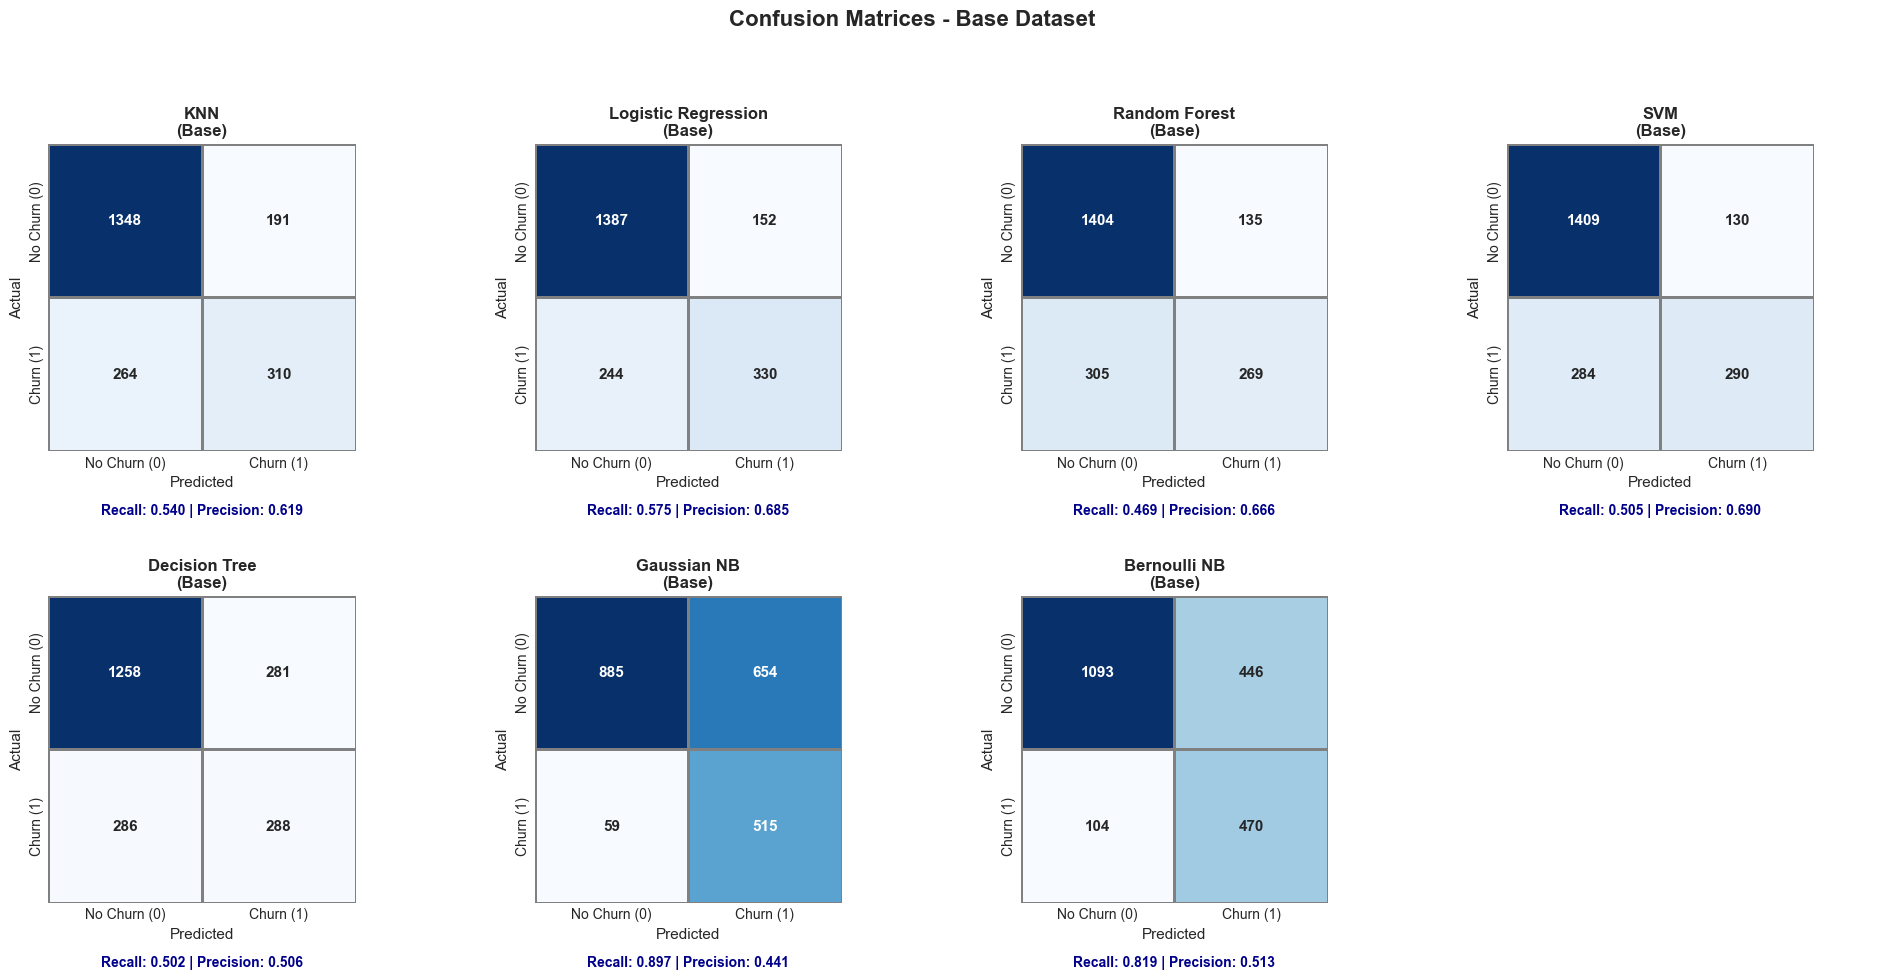


CONFUSION MATRICES - РАСШИРЕННЫЙ ДАТАСЕТ


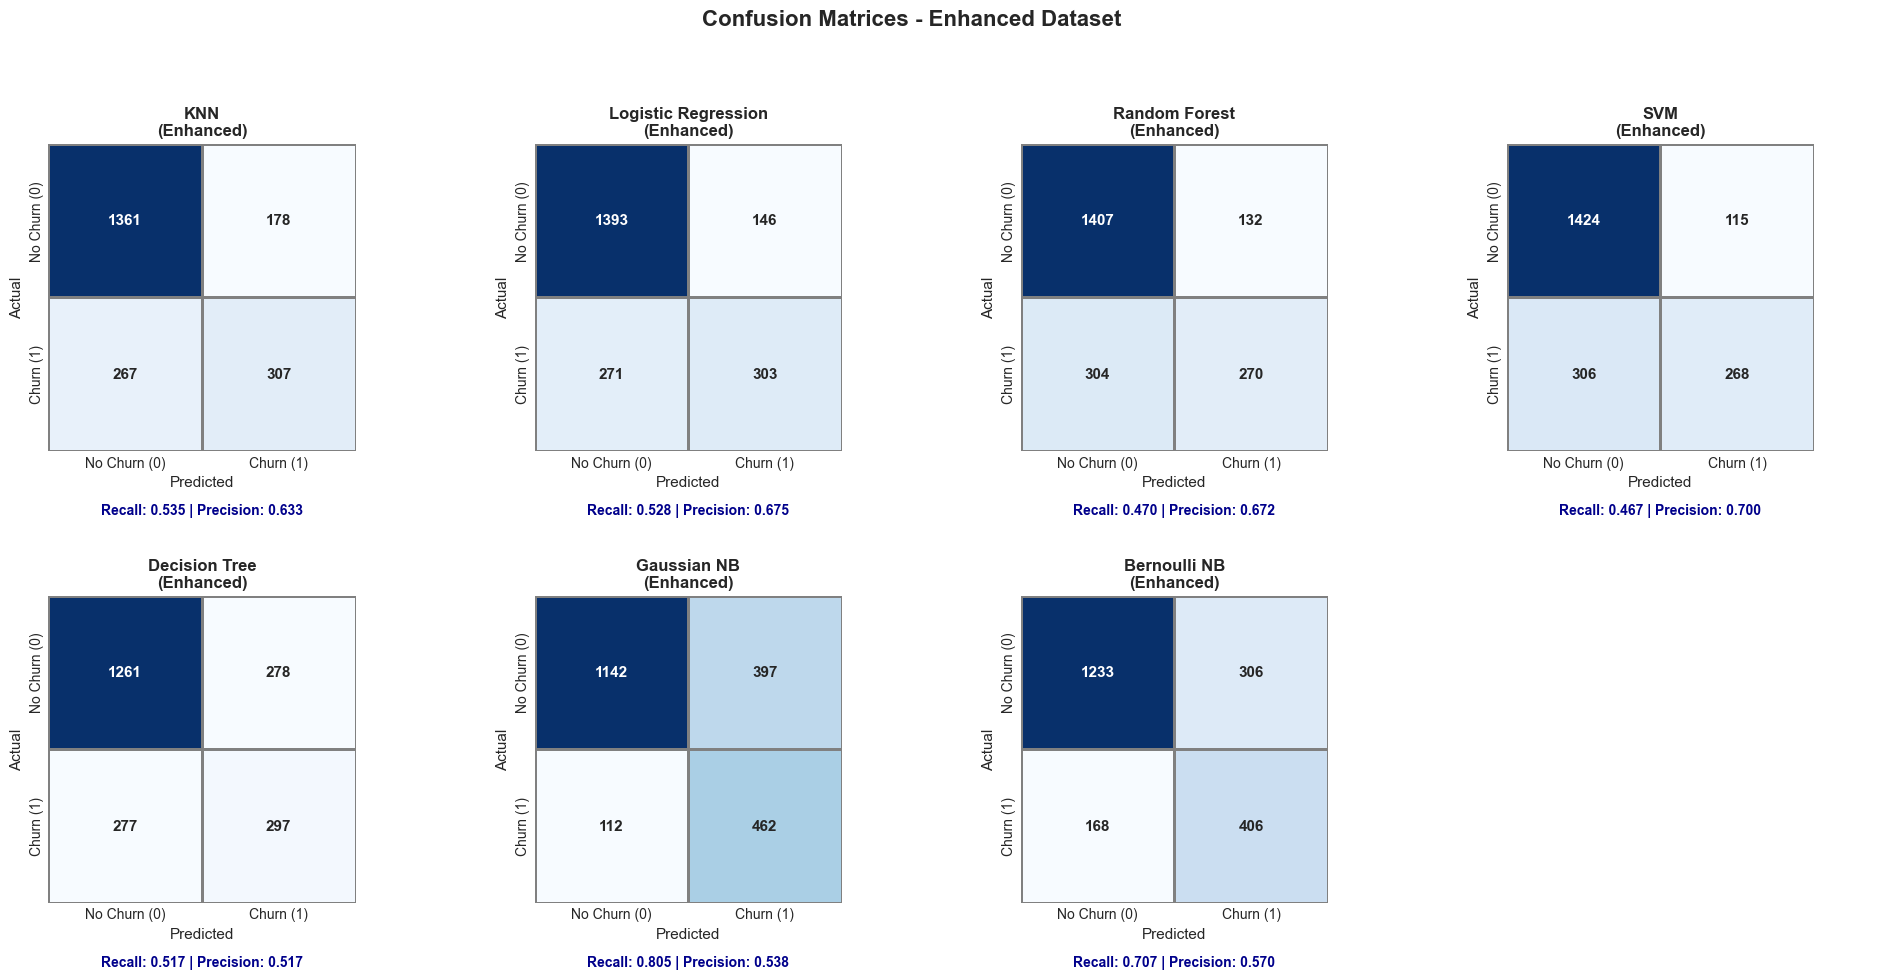

In [444]:
# Визуализация Confusion Matrix для всех моделей
from sklearn.metrics import confusion_matrix

# Функция для построения confusion matrix
def plot_confusion_matrices(models_dict, X_train, X_test, y_train, y_test, dataset_name):
    """Строит confusion matrix для всех моделей"""
    n_models = len(models_dict)
    n_cols = 4
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Переобучаем модель на правильном датасете
        model.fit(X_train, y_train)
        
        # Предсказания
        y_pred = model.predict(X_test)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Визуализация
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    cbar=False, square=True, linewidths=1, linecolor='gray',
                    annot_kws={'fontsize': 11, 'fontweight': 'bold'})
        
        axes[idx].set_title(f'{name}\n({dataset_name})', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=11)
        axes[idx].set_xlabel('Predicted', fontsize=11)
        axes[idx].set_xticklabels(['No Churn (0)', 'Churn (1)'], fontsize=10)
        axes[idx].set_yticklabels(['No Churn (0)', 'Churn (1)'], fontsize=10)
        
        # Добавляем метрики на график
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        axes[idx].text(0.5, -0.17, f'Recall: {recall:.3f} | Precision: {precision:.3f}', 
                      ha='center', va='top', transform=axes[idx].transAxes, 
                      fontsize=10, color='darkblue', fontweight='bold')
    
    # Скрываем лишние subplot'ы
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Confusion Matrices - {dataset_name} Dataset', 
                 fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout(pad=3.0, h_pad=3.5, w_pad=2.0)
    plt.show()

# Confusion matrices для базового датасета
print("\n" + "="*70)
print("CONFUSION MATRICES - БАЗОВЫЙ ДАТАСЕТ")
print("="*70)
plot_confusion_matrices(models, X_train_base_ohe, X_test_base_ohe, 
                        y_train_base_ohe, y_test_base_ohe, 'Base')

# Confusion matrices для расширенного датасета
print("\n" + "="*70)
print("CONFUSION MATRICES - РАСШИРЕННЫЙ ДАТАСЕТ")
print("="*70)
plot_confusion_matrices(models, X_train_enh_ohe, X_test_enh_ohe, 
                        y_train_enh_ohe, y_test_enh_ohe, 'Enhanced')

## 6. Бустинговые модели

Теперь обучим бустинговые модели, которые часто показывают лучшие результаты:
- **XGBoost**
- **LightGBM**
- **CatBoost**
- **AdaBoost**

In [445]:
# Инициализация бустинговых моделей
boosting_models = {
    'XGBoost': XGBClassifier(random_state=101, eval_metric='logloss', n_estimators=500),
    'LightGBM': LGBMClassifier(n_estimators=200,learning_rate=0.1,max_depth=11,num_leaves=31,random_state=42,verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0,n_estimators=1000, learning_rate=0.05, depth=11),
    'AdaBoost': AdaBoostClassifier(n_estimators=1877,learning_rate=0.02,random_state=42,algorithm='SAMME'),
}

print("="*70)
print("ИНИЦИАЛИЗИРОВАНЫ БУСТИНГОВЫЕ МОДЕЛИ:")
print("="*70)
for name in boosting_models.keys():
    print(f"  ✓ {name}")
print("="*70)

ИНИЦИАЛИЗИРОВАНЫ БУСТИНГОВЫЕ МОДЕЛИ:
  ✓ XGBoost
  ✓ LightGBM
  ✓ CatBoost
  ✓ AdaBoost


### 6.1. Обучение на базовом датасете

In [446]:
# Используем ту же функцию train_and_evaluate - она универсальная!
results_boost_base = train_and_evaluate(
    boosting_models, X_train_base, X_test_base, 
    y_train_base, y_test_base, 'Base (Boosting)'
)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ БУСТИНГОВЫХ МОДЕЛЕЙ НА БАЗОВОМ ДАТАСЕТЕ")
print("="*70)
print(results_boost_base[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))


ОБУЧЕНИЕ МОДЕЛЕЙ: Base (Boosting)

 Обучение XGBoost...  F1: 0.5617 | Recall: 0.5157

 Обучение LightGBM...  F1: 0.5712 | Recall: 0.5174

 Обучение CatBoost...  F1: 0.5576 | Recall: 0.5017

 Обучение AdaBoost...  F1: 0.5265 | Recall: 0.4321

РЕЗУЛЬТАТЫ БУСТИНГОВЫХ МОДЕЛЕЙ НА БАЗОВОМ ДАТАСЕТЕ
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
 XGBoost  0.781354   0.616667 0.515679  0.561670 0.816635
LightGBM  0.788926   0.637339 0.517422  0.571154 0.839099
CatBoost  0.783720   0.627451 0.501742  0.557599 0.825057
AdaBoost  0.788926   0.673913 0.432056  0.526539 0.853779


### 6.2. Обучение на расширенном датасете

In [447]:
results_boost_enh = train_and_evaluate(
    boosting_models, X_train_enh, X_test_enh, 
    y_train_enh, y_test_enh, 'Enhanced (Boosting)'
)

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ БУСТИНГОВЫХ МОДЕЛЕЙ НА РАСШИРЕННОМ ДАТАСЕТЕ")
print("="*70)
print(results_boost_enh[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))


ОБУЧЕНИЕ МОДЕЛЕЙ: Enhanced (Boosting)

 Обучение XGBoost...  F1: 0.5352 | Recall: 0.4895

 Обучение LightGBM...  F1: 0.5806 | Recall: 0.5366

 Обучение CatBoost...  F1: 0.5595 | Recall: 0.5035

 Обучение AdaBoost...  F1: 0.5224 | Recall: 0.4164

РЕЗУЛЬТАТЫ БУСТИНГОВЫХ МОДЕЛЕЙ НА РАСШИРЕННОМ ДАТАСЕТЕ
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
 XGBoost  0.769049   0.590336 0.489547  0.535238 0.810265
LightGBM  0.789399   0.632444 0.536585  0.580584 0.836635
CatBoost  0.784666   0.629630 0.503484  0.559535 0.826821
AdaBoost  0.793185   0.700880 0.416376  0.522404 0.854961


### 6.3. Сравнение всех моделей (базовые + бустинговые)

In [448]:
# Объединяем результаты всех моделей
all_results_with_boosting = pd.concat([
    all_results,           # базовые модели на обоих датасетах
    results_boost_base,    # бустинговые модели на базовом датасете
    results_boost_enh      # бустинговые модели на расширенном датасете
], ignore_index=True)

# Сортируем по F1-Score
results_sorted_f1 = all_results_with_boosting.sort_values(by='F1-Score', ascending=False)

# Сортируем по Recall
results_sorted_recall = all_results_with_boosting.sort_values(by='Recall', ascending=False)

print("="*90)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ (отсортировано по F1-Score)")
print("="*90)
print(results_sorted_f1[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

print("\n" + "="*90)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ (отсортировано по Recall)")
print("="*90)
print(results_sorted_recall[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

ИТОГОВЫЕ РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ (отсортировано по F1-Score)
              Model             Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC
        Gaussian NB            Enhanced  0.759110   0.537835 0.804878  0.644801 0.838835
       Bernoulli NB            Enhanced  0.775674   0.570225 0.707317  0.631415 0.841681
       Bernoulli NB                Base  0.739707   0.513100 0.818815  0.630872 0.830675
Logistic Regression                Base  0.812589   0.684647 0.574913  0.625000 0.858762
Logistic Regression            Enhanced  0.802650   0.674833 0.527875  0.592375 0.857707
        Gaussian NB                Base  0.662565   0.440547 0.897213  0.590935 0.829032
                SVM                Base  0.804070   0.690476 0.505226  0.583501 0.818030
           LightGBM Enhanced (Boosting)  0.789399   0.632444 0.536585  0.580584 0.836635
                KNN            Enhanced  0.789399   0.632990 0.534843  0.579792 0.823796
                KNN                Base  0.784666

### 6.4. Confusion Matrices для бустинговых моделей

**6.4.1. Базовый датасет**

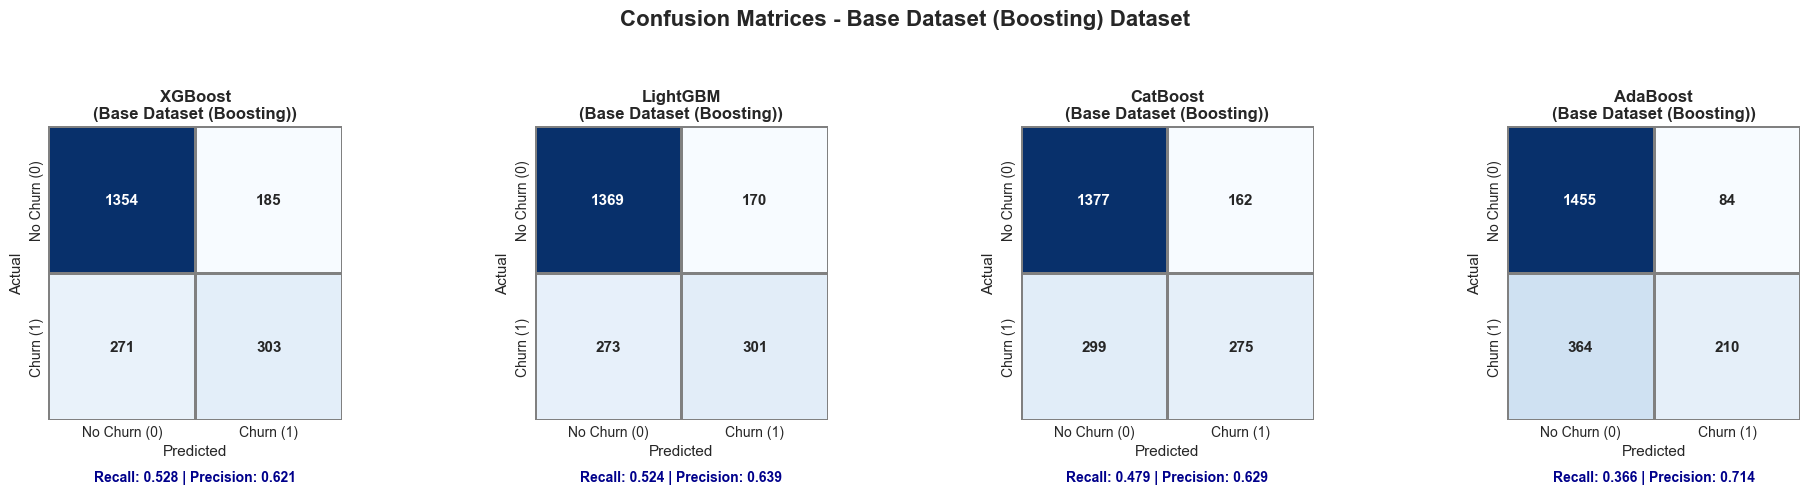

In [449]:
plot_confusion_matrices(
    boosting_models, 
    X_train_base_ohe, X_test_base_ohe, 
    y_train_base_ohe, y_test_base_ohe, 
    'Base Dataset (Boosting)'
)

**6.4.2. Расширенный датасет**

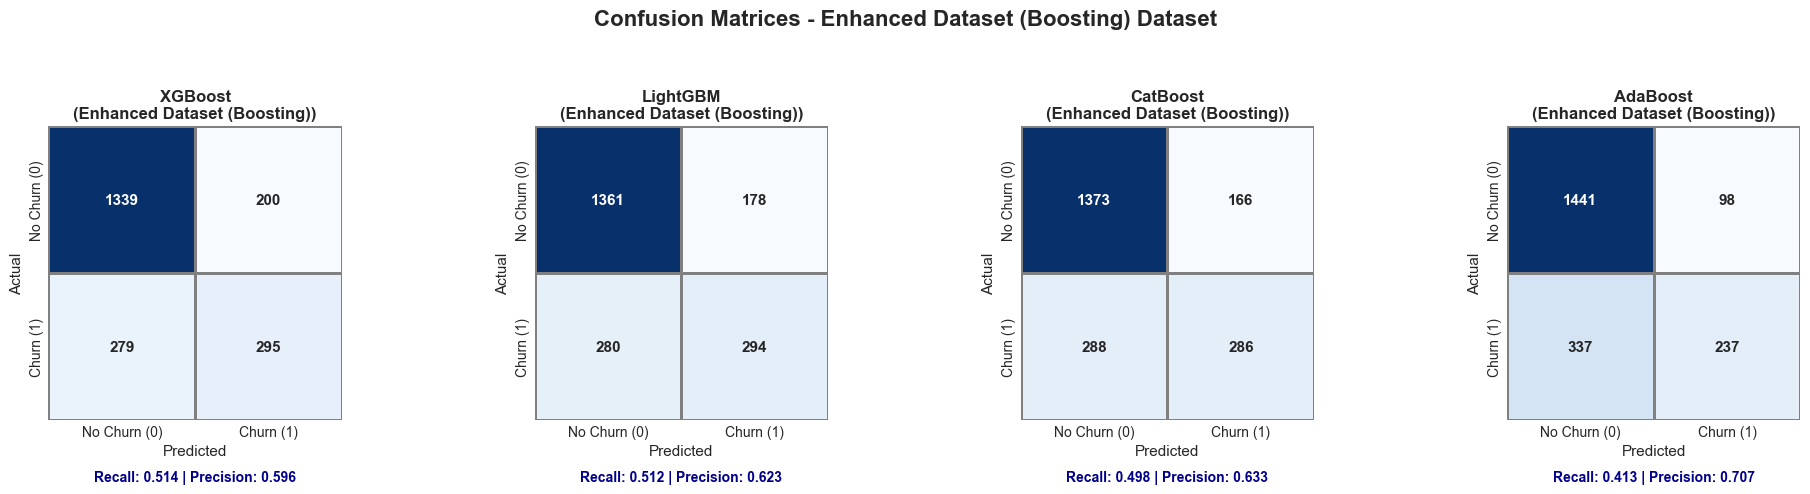

In [450]:
plot_confusion_matrices(
    boosting_models, 
    X_train_enh_ohe, X_test_enh_ohe, 
    y_train_enh_ohe, y_test_enh_ohe, 
    'Enhanced Dataset (Boosting)'
)

## 7. Балансировка классов с SMOTENC

Теперь применим **SMOTENC** для балансировки классов. SMOTENC учитывает категориальные признаки при генерации синтетических примеров.

**Важно:** 
- SMOTENC применяется **ТОЛЬКО к train данным** после разделения
- Test данные остаются несбалансированными (как в реальности)
- Используем данные с **LabelEncoder** (SMOTENC работает с mixed data)

In [451]:
from imblearn.over_sampling import SMOTENC

print("="*70)
print("ПРИМЕНЕНИЕ SMOTENC ДЛЯ БАЛАНСИРОВКИ КЛАССОВ")
print("="*70)

# Для SMOTENC нужны индексы категориальных признаков в данных с LabelEncoder
# У нас уже подготовлены categorical_indices_base и categorical_indices_enhanced

print("\n1. БАЗОВЫЙ ДАТАСЕТ")
print(f"   Категориальные признаки: {len(categorical_indices_base)}")
print(f"   Индексы: {categorical_indices_base}")

# Применяем SMOTENC к базовому датасету
smote_base = SMOTENC(categorical_features=categorical_indices_base, random_state=RANDOM_STATE, k_neighbors=5)
X_train_base_smote, y_train_base_smote = smote_base.fit_resample(X_train_base, y_train_base)

print(f"\n   ДО SMOTENC:")
print(f"      X_train: {X_train_base.shape}")
print(f"      y_train: No Churn = {(y_train_base == 0).sum()} | Churn = {(y_train_base == 1).sum()}")
print(f"      Баланс: {(y_train_base == 0).sum() / (y_train_base == 1).sum():.2f}:1")

print(f"\n   ПОСЛЕ SMOTENC:")
print(f"      X_train: {X_train_base_smote.shape}")
print(f"      y_train: No Churn = {(y_train_base_smote == 0).sum()} | Churn = {(y_train_base_smote == 1).sum()}")
print(f"      Баланс: {(y_train_base_smote == 0).sum() / (y_train_base_smote == 1).sum():.2f}:1")
print(f"      Добавлено примеров: +{X_train_base_smote.shape[0] - X_train_base.shape[0]}")

print("\n" + "="*70)

print("\n2. РАСШИРЕННЫЙ ДАТАСЕТ")
print(f"   Категориальные признаки: {len(categorical_indices_enhanced)}")
print(f"   Индексы: {categorical_indices_enhanced}")

# Применяем SMOTENC к расширенному датасету
smote_enh = SMOTENC(categorical_features=categorical_indices_enhanced, random_state=RANDOM_STATE, k_neighbors=5)
X_train_enh_smote, y_train_enh_smote = smote_enh.fit_resample(X_train_enh, y_train_enh)

print(f"\n   ДО SMOTENC:")
print(f"      X_train: {X_train_enh.shape}")
print(f"      y_train: No Churn = {(y_train_enh == 0).sum()} | Churn = {(y_train_enh == 1).sum()}")
print(f"      Баланс: {(y_train_enh == 0).sum() / (y_train_enh == 1).sum():.2f}:1")

print(f"\n   ПОСЛЕ SMOTENC:")
print(f"      X_train: {X_train_enh_smote.shape}")
print(f"      y_train: No Churn = {(y_train_enh_smote == 0).sum()} | Churn = {(y_train_enh_smote == 1).sum()}")
print(f"      Баланс: {(y_train_enh_smote == 0).sum() / (y_train_enh_smote == 1).sum():.2f}:1")
print(f"      Добавлено примеров: +{X_train_enh_smote.shape[0] - X_train_enh.shape[0]}")

ПРИМЕНЕНИЕ SMOTENC ДЛЯ БАЛАНСИРОВКИ КЛАССОВ

1. БАЗОВЫЙ ДАТАСЕТ
   Категориальные признаки: 16
   Индексы: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1]

   ДО SMOTENC:
      X_train: (4930, 19)
      y_train: No Churn = 3635 | Churn = 1295
      Баланс: 2.81:1

   ПОСЛЕ SMOTENC:
      X_train: (7270, 19)
      y_train: No Churn = 3635 | Churn = 3635
      Баланс: 1.00:1
      Добавлено примеров: +2340


2. РАСШИРЕННЫЙ ДАТАСЕТ
   Категориальные признаки: 20
   Индексы: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 1, 20, 22, 21]

   ДО SMOTENC:
      X_train: (4930, 25)
      y_train: No Churn = 3635 | Churn = 1295
      Баланс: 2.81:1

   ПОСЛЕ SMOTENC:
      X_train: (7270, 25)
      y_train: No Churn = 3635 | Churn = 3635
      Баланс: 1.00:1
      Добавлено примеров: +2340


### 7.1. Обучение базовых моделей на SMOTENC данных

Теперь обучим те же модели на сбалансированных данных и сравним результаты.

CONFUSION MATRICES - БУСТИНГ + РАСШИРЕННЫЙ ДАТАСЕТ + SMOTENC


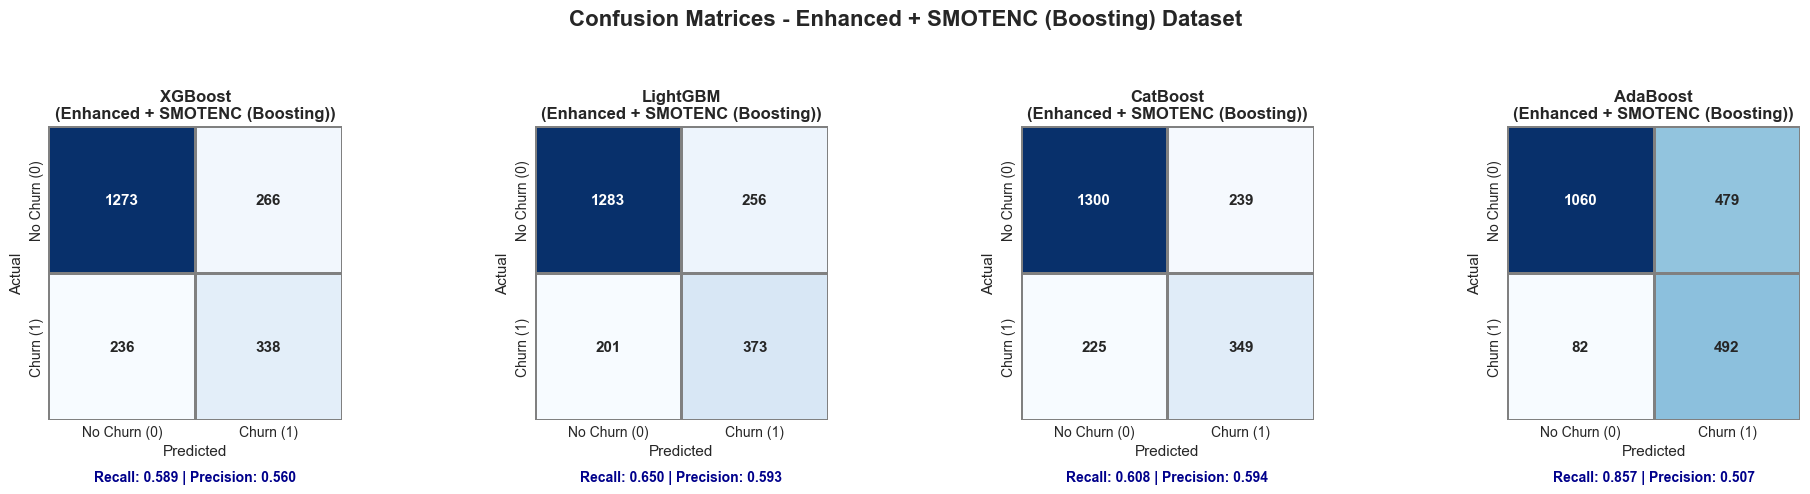

In [452]:
# Confusion matrices для бустинговых моделей с SMOTENC (Enhanced)
print("="*70)
print("CONFUSION MATRICES - БУСТИНГ + РАСШИРЕННЫЙ ДАТАСЕТ + SMOTENC")
print("="*70)
plot_confusion_matrices(
    boosting_models, 
    X_train_enh_smote, X_test_enh, 
    y_train_enh_smote, y_test_enh, 
    'Enhanced + SMOTENC (Boosting)'
)

CONFUSION MATRICES - БУСТИНГ + БАЗОВЫЙ ДАТАСЕТ + SMOTENC


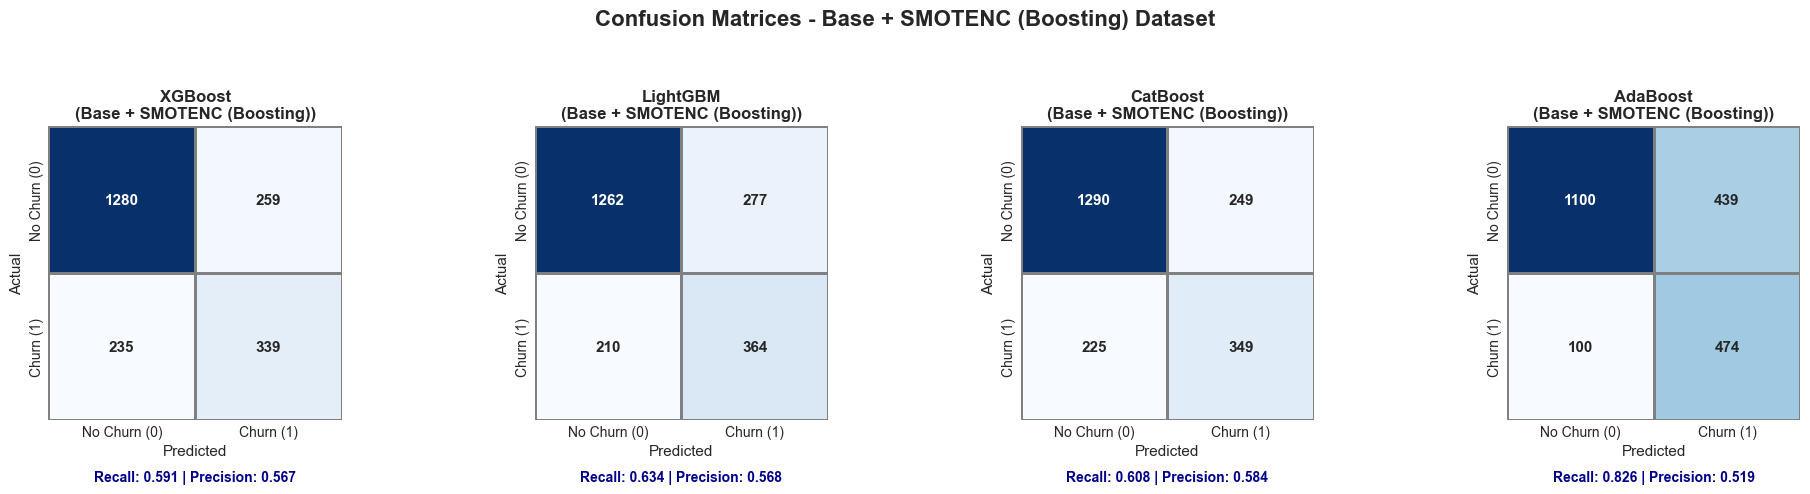

In [453]:
# Confusion matrices для бустинговых моделей с SMOTENC (Base)
print("="*70)
print("CONFUSION MATRICES - БУСТИНГ + БАЗОВЫЙ ДАТАСЕТ + SMOTENC")
print("="*70)
plot_confusion_matrices(
    boosting_models, 
    X_train_base_smote, X_test_base, 
    y_train_base_smote, y_test_base, 
    'Base + SMOTENC (Boosting)'
)

CONFUSION MATRICES - РАСШИРЕННЫЙ ДАТАСЕТ + SMOTENC


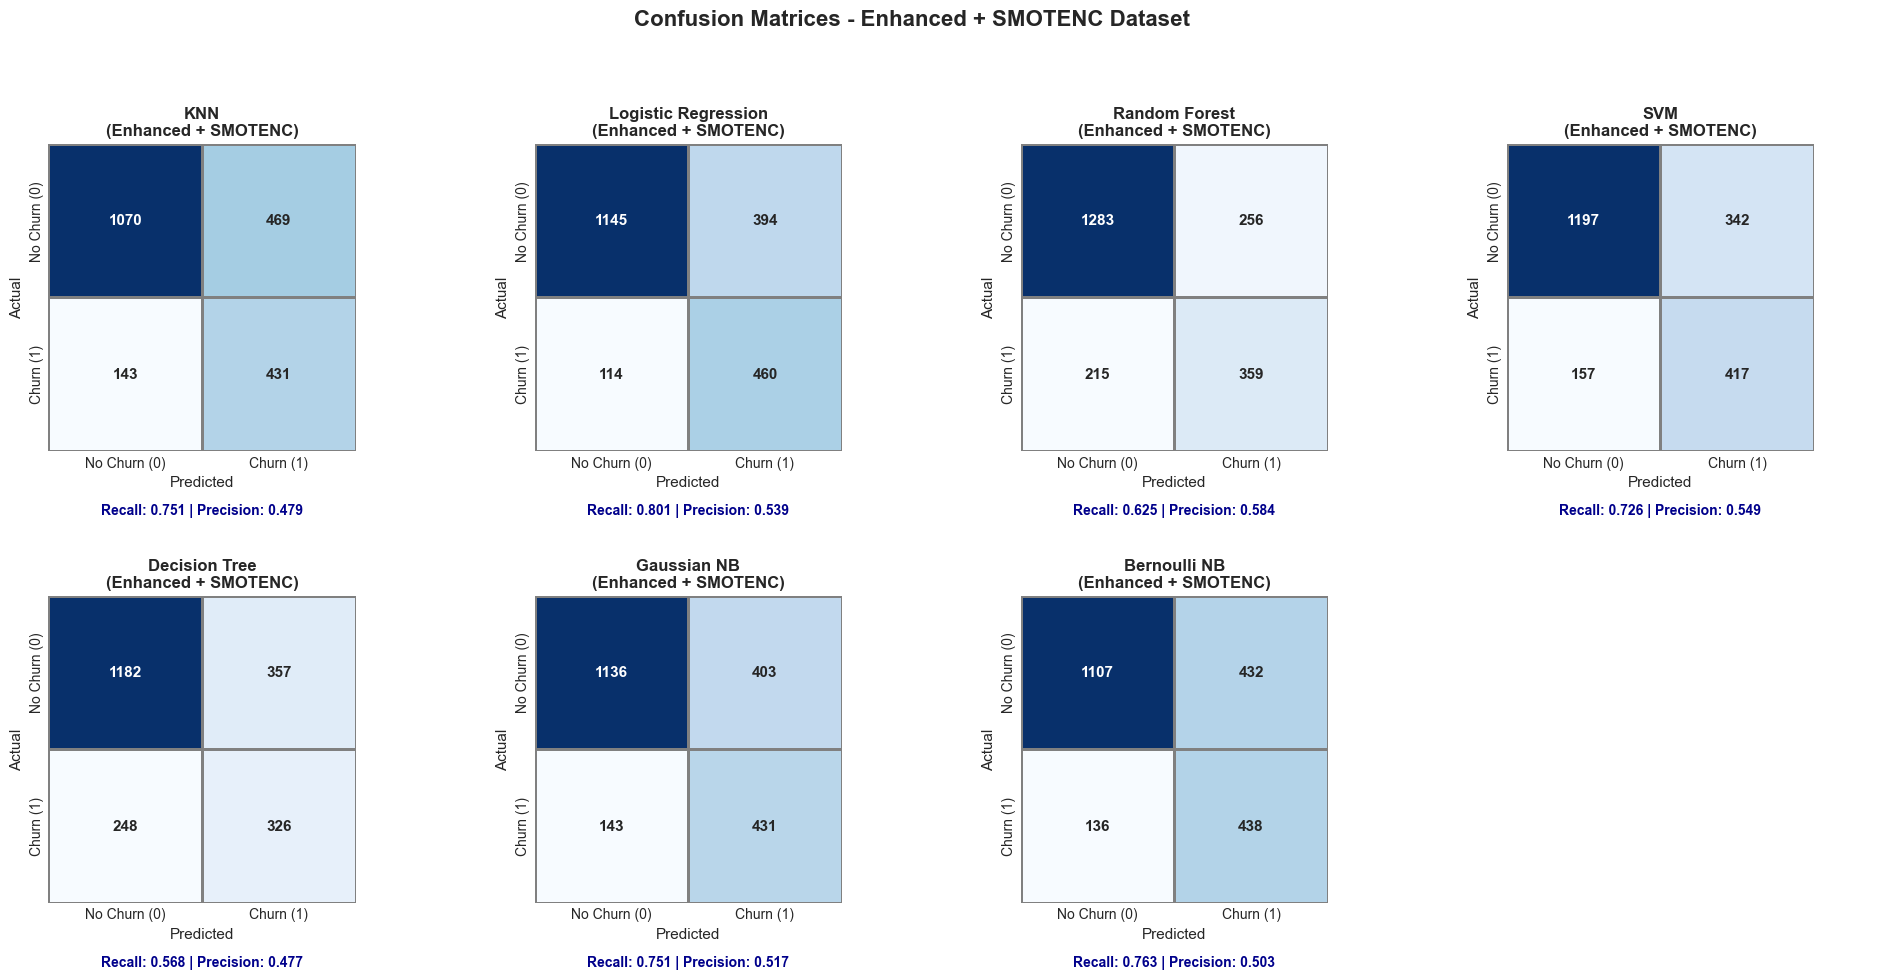

In [454]:
# Confusion matrices для базовых моделей с SMOTENC (Enhanced)
print("="*70)
print("CONFUSION MATRICES - РАСШИРЕННЫЙ ДАТАСЕТ + SMOTENC")
print("="*70)
plot_confusion_matrices(
    models, 
    X_train_enh_smote, X_test_enh, 
    y_train_enh_smote, y_test_enh, 
    'Enhanced + SMOTENC'
)

CONFUSION MATRICES - БАЗОВЫЙ ДАТАСЕТ + SMOTENC


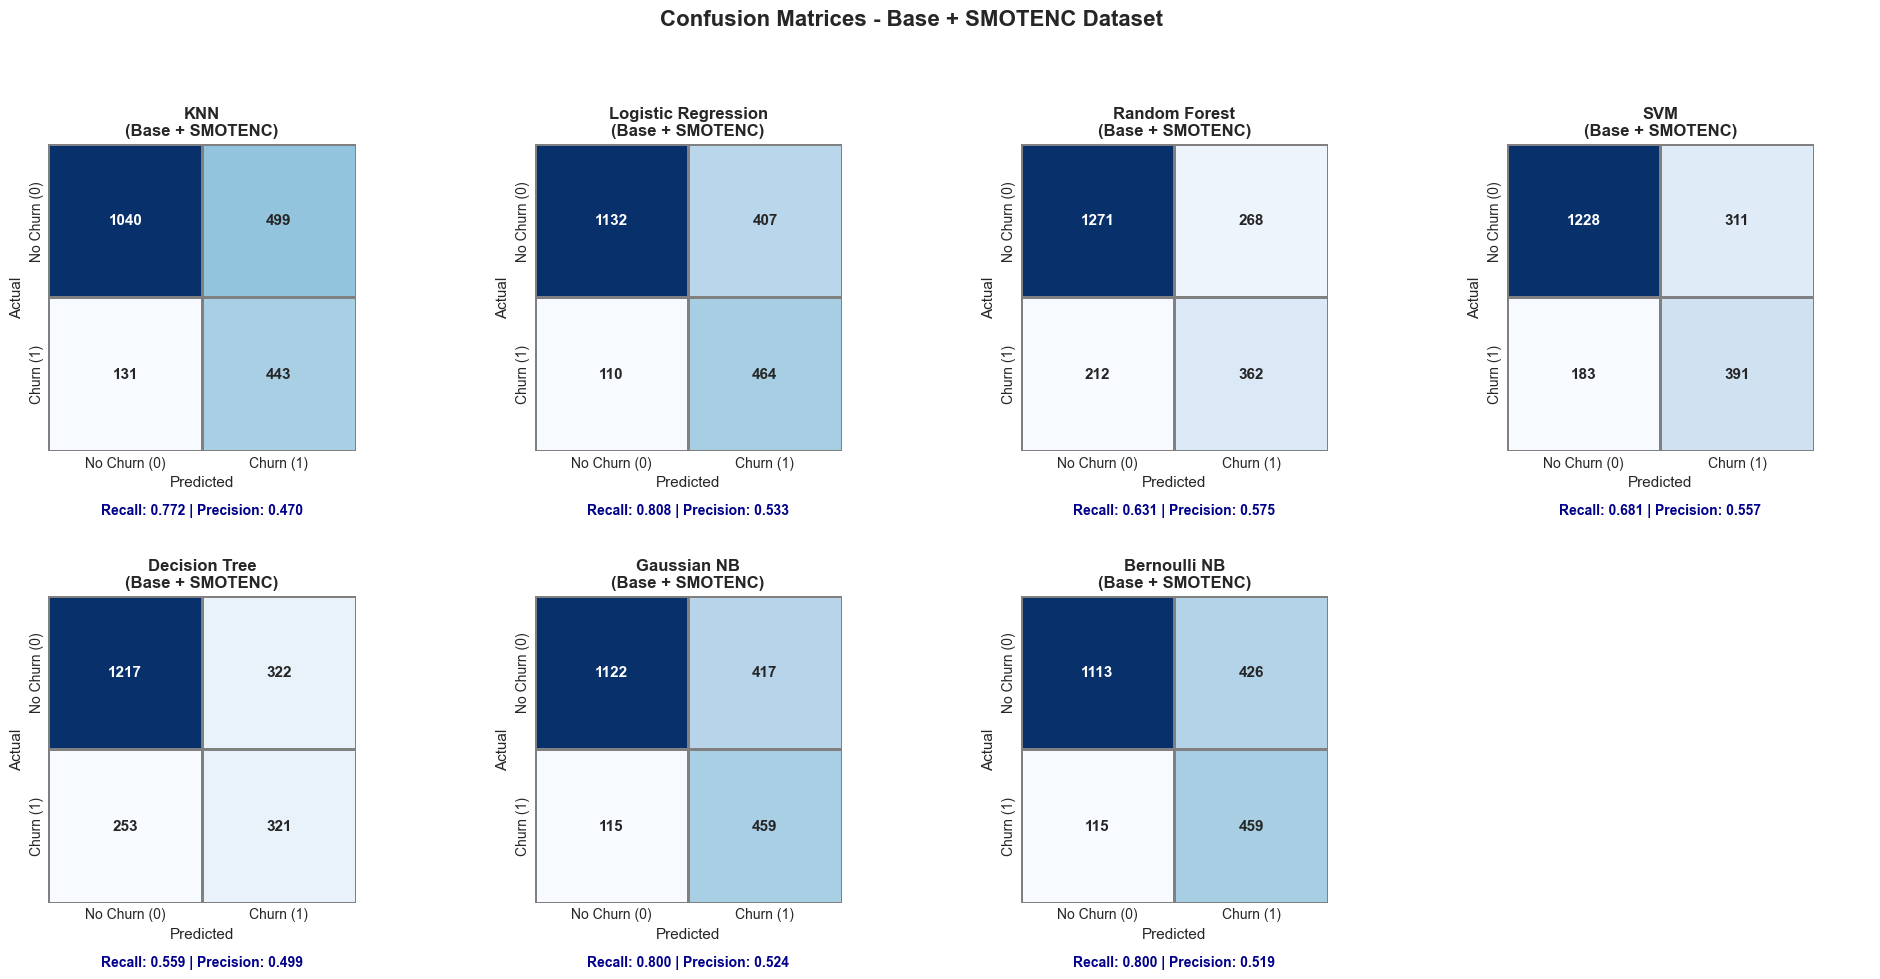

In [455]:
# Confusion matrices для базовых моделей с SMOTENC (Base)
print("="*70)
print("CONFUSION MATRICES - БАЗОВЫЙ ДАТАСЕТ + SMOTENC")
print("="*70)
plot_confusion_matrices(
    models, 
    X_train_base_smote, X_test_base, 
    y_train_base_smote, y_test_base, 
    'Base + SMOTENC'
)

### 7.6. Confusion Matrices для моделей с SMOTENC

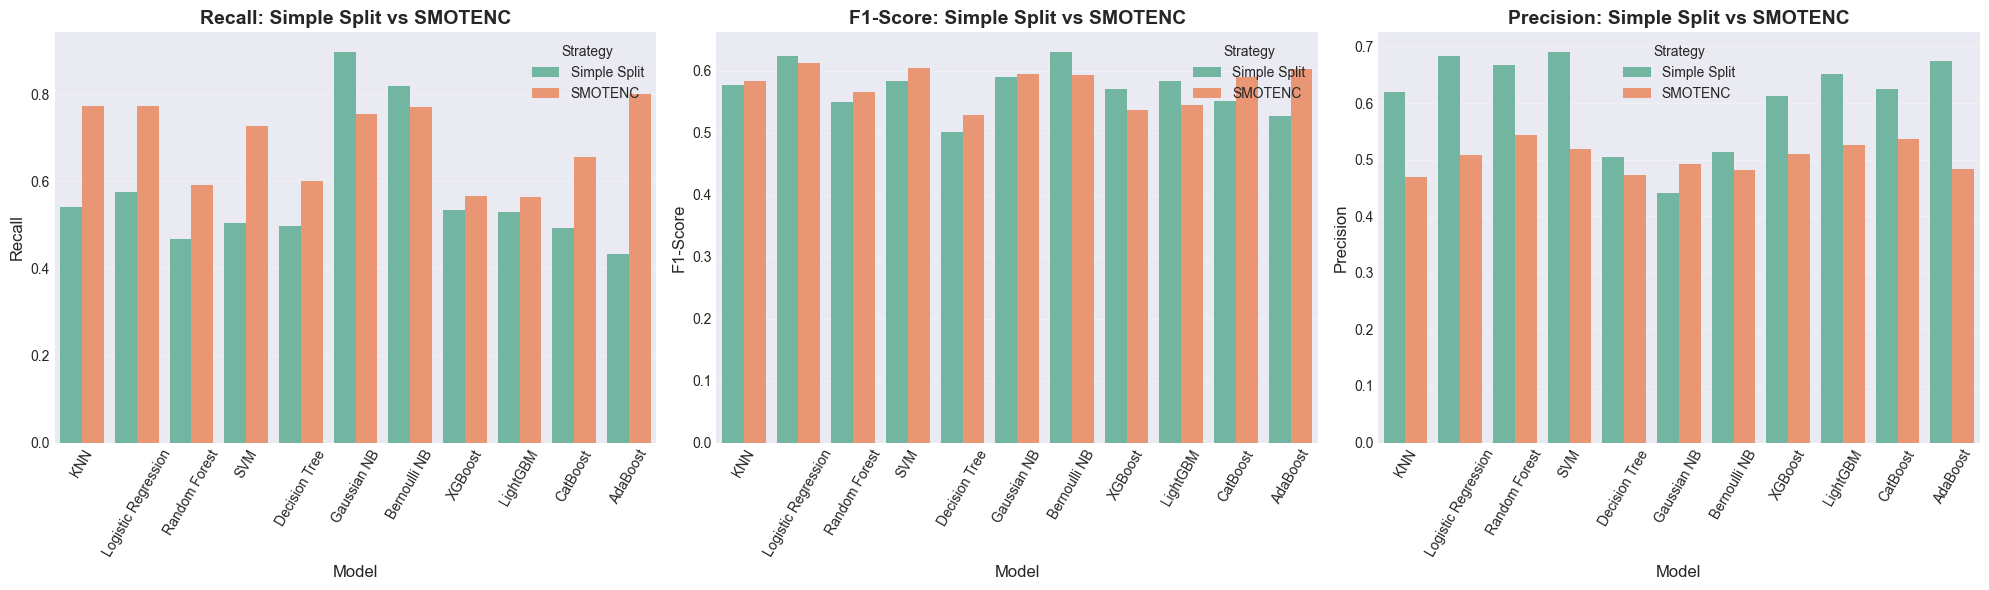

 Визуализация построена!


In [456]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем датафрейм для сравнения
comparison_data = []

for model_name in list(models.keys()) + list(boosting_models.keys()):
    # Simple Split - Base
    simple_base = final_all_results[
        (final_all_results['Model'] == model_name) & 
        (final_all_results['Dataset'].str.contains('Base')) & 
        (~final_all_results['Dataset'].str.contains('SMOTENC'))
    ]
    
    # SMOTENC - Base
    smote_base = final_all_results[
        (final_all_results['Model'] == model_name) & 
        (final_all_results['Dataset'].str.contains('Base')) & 
        (final_all_results['Dataset'].str.contains('SMOTENC'))
    ]
    
    if not simple_base.empty and not smote_base.empty:
        comparison_data.append({
            'Model': model_name,
            'Strategy': 'Simple Split',
            'Recall': simple_base['Recall'].values[0],
            'F1-Score': simple_base['F1-Score'].values[0],
            'Precision': simple_base['Precision'].values[0]
        })
        comparison_data.append({
            'Model': model_name,
            'Strategy': 'SMOTENC',
            'Recall': smote_base['Recall'].values[0],
            'F1-Score': smote_base['F1-Score'].values[0],
            'Precision': smote_base['Precision'].values[0]
        })

comparison_df = pd.DataFrame(comparison_data)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Recall
sns.barplot(data=comparison_df, x='Model', y='Recall', hue='Strategy', ax=axes[0], palette='Set2')
axes[0].set_title('Recall: Simple Split vs SMOTENC', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Recall', fontsize=12)
axes[0].tick_params(axis='x', rotation=60)
axes[0].legend(title='Strategy', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# F1-Score
sns.barplot(data=comparison_df, x='Model', y='F1-Score', hue='Strategy', ax=axes[1], palette='Set2')
axes[1].set_title('F1-Score: Simple Split vs SMOTENC', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=60)
axes[1].legend(title='Strategy', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# Precision
sns.barplot(data=comparison_df, x='Model', y='Precision', hue='Strategy', ax=axes[2], palette='Set2')
axes[2].set_title('Precision: Simple Split vs SMOTENC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('Precision', fontsize=12)
axes[2].tick_params(axis='x', rotation=60)
axes[2].legend(title='Strategy', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(" Визуализация построена!")

### 7.5. Визуализация сравнения Simple vs SMOTENC

In [457]:
# Объединяем ВСЕ результаты
final_all_results = pd.concat([
    all_results,                    # Базовые модели: Simple Split
    results_boost_base,             # Бустинговые: Base + Simple
    results_boost_enh,              # Бустинговые: Enhanced + Simple
    results_base_smote,             # Базовые: Base + SMOTENC
    results_enh_smote,              # Базовые: Enhanced + SMOTENC
    results_boost_base_smote,       # Бустинговые: Base + SMOTENC
    results_boost_enh_smote         # Бустинговые: Enhanced + SMOTENC
], ignore_index=True)

print("="*100)
print("ФИНАЛЬНАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ (ТОП-20 по F1-Score)")
print("="*100)
top_20_f1 = final_all_results.sort_values('F1-Score', ascending=False).head(20)
print(top_20_f1[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

print("\n" + "="*100)
print("ФИНАЛЬНАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ (ТОП-20 по Recall)")
print("="*100)
top_20_recall = final_all_results.sort_values('Recall', ascending=False).head(20)
print(top_20_recall[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

# Лучшая модель
best_model = final_all_results.loc[final_all_results['Recall'].idxmax()]

print("\n" + "="*100)
print(" ЛУЧШАЯ МОДЕЛЬ (по Recall):")
print("="*100)
print(f"  Модель:      {best_model['Model']}")
print(f"  Датасет:     {best_model['Dataset']}")
print(f"  Recall:      {best_model['Recall']:.4f} ({best_model['Recall']*100:.1f}%)")
print(f"  Precision:   {best_model['Precision']:.4f}")
print(f"  F1-Score:    {best_model['F1-Score']:.4f}")
print(f"  Accuracy:    {best_model['Accuracy']:.4f}")
print(f"  ROC-AUC:     {best_model['ROC-AUC']:.4f}")
print("="*100)

ФИНАЛЬНАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ (ТОП-20 по F1-Score)
              Model                       Dataset  Accuracy  Precision   Recall  F1-Score  ROC-AUC
        Gaussian NB                      Enhanced  0.759110   0.537835 0.804878  0.644801 0.838835
       Bernoulli NB                      Enhanced  0.775674   0.570225 0.707317  0.631415 0.841681
       Bernoulli NB                          Base  0.739707   0.513100 0.818815  0.630872 0.830675
Logistic Regression                          Base  0.812589   0.684647 0.574913  0.625000 0.858762
Logistic Regression                Base + SMOTENC  0.740583   0.507909 0.772727  0.612937 0.826949
Logistic Regression            Enhanced + SMOTENC  0.739872   0.507092 0.764706  0.609808 0.832178
           AdaBoost Enhanced + SMOTENC (Boosting)  0.724947   0.489465 0.807487  0.609485 0.834216
                SVM                Base + SMOTENC  0.747690   0.518095 0.727273  0.605117 0.798854
           AdaBoost     Base + SMOTENC (Boosting)  

## 8. Оптимизация гиперпараметров с GridSearchCV

Попробуем улучшить производительность линейных моделей (Logistic Regression, Gaussian NB, Bernoulli NB) с помощью подбора оптимальных гиперпараметров.

In [458]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print("="*80)
print("ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С GRIDSEARCHCV")
print("="*80)

# Параметры для поиска
param_grids = {
    'BernoulliNB': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_prior': [True, False]
    },
    'GaussianNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 0.5, 1, 5, 10],
        'penalty': ['l2','l1'],
        'solver': ['lbfgs', 'saga'],
        'class_weight': [None, 'balanced']
    }
}

# Модели для оптимизации
models_to_optimize = {
    'BernoulliNB': BernoulliNB(),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
}

# Результаты GridSearch
grid_results = {}

for model_name, model in models_to_optimize.items():
    print(f"\n{'='*80}")
    print(f" GridSearch для {model_name}")
    print(f"{'='*80}")
    
    # GridSearchCV с 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='recall',  # Оптимизируем по Recall (важно для churn!)
        n_jobs=-1,
        verbose=1
    )
    
    # Обучаем на расширенном датасете с SMOTENC (лучшие результаты)
    print(f"\n⏳ Обучение на Enhanced + SMOTENC...")
    grid_search.fit(X_train_enh_smote, y_train_enh_smote)
    
    # Лучшие параметры
    print(f"\n Лучшие параметры:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")
    
    print(f"\n Лучший Recall (CV): {grid_search.best_score_:.4f}")
    
    # Предсказания на тестовой выборке
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_enh)
    y_pred_proba = best_model.predict_proba(X_test_enh)[:, 1]
    
    # Метрики на тесте
    test_metrics = evaluate_model(y_test_enh, y_pred, y_pred_proba)
    
    print(f"\n  Результаты на тестовой выборке:")
    print(f"   Recall:    {test_metrics['Recall']:.4f}")
    print(f"   Precision: {test_metrics['Precision']:.4f}")
    print(f"   F1-Score:  {test_metrics['F1-Score']:.4f}")
    print(f"   ROC-AUC:   {test_metrics['ROC-AUC']:.4f}")
    
    # Сохраняем результаты
    grid_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score_cv': grid_search.best_score_,
        'best_model': best_model,
        'test_metrics': test_metrics
    }

print(f"\n{'='*80}")
print(" ОПТИМИЗАЦИЯ ЗАВЕРШЕНА")
print(f"{'='*80}")

ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С GRIDSEARCHCV

 GridSearch для BernoulliNB

⏳ Обучение на Enhanced + SMOTENC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Лучшие параметры:
   alpha: 0.1
   fit_prior: True

 Лучший Recall (CV): 0.7568

  Результаты на тестовой выборке:
   Recall:    0.7631
   Precision: 0.5034
   F1-Score:  0.6066
   ROC-AUC:   0.8127

 GridSearch для GaussianNB

⏳ Обучение на Enhanced + SMOTENC...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Лучшие параметры:
   var_smoothing: 1e-09

 Лучший Recall (CV): 0.7554

  Результаты на тестовой выборке:
   Recall:    0.7509
   Precision: 0.5168
   F1-Score:  0.6122
   ROC-AUC:   0.8257

 GridSearch для LogisticRegression

⏳ Обучение на Enhanced + SMOTENC...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Лучшие параметры:
   C: 0.01
   class_weight: None
   penalty: l1
   solver: saga

 Лучший Recall (CV): 0.8138

  Результаты на тестовой выборке:
   Recall:    0.8171
   Precis

### 8.1. Сравнение: До и После оптимизации

In [459]:
# Сравнение результатов до и после GridSearch
print("="*100)
print("СРАВНЕНИЕ: ДО И ПОСЛЕ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ")
print("="*100)

# Маппинг названий моделей: GridSearch название -> название в final_all_results
model_name_mapping = {
    'BernoulliNB': 'Bernoulli NB',
    'GaussianNB': 'Gaussian NB',
    'LogisticRegression': 'Logistic Regression'
}

comparison_table = []

for model_name in models_to_optimize.keys():
    # Получаем название модели из final_all_results
    original_name = model_name_mapping.get(model_name, model_name)
    
    # Результаты ДО оптимизации (из final_all_results)
    before = final_all_results[
        (final_all_results['Model'] == original_name) & 
        (final_all_results['Dataset'].str.contains('Enhanced')) & 
        (final_all_results['Dataset'].str.contains('SMOTENC'))
    ]
    
    # Результаты ПОСЛЕ оптимизации
    after = grid_results[model_name]['test_metrics']
    
    if not before.empty:
        comparison_table.append({
            'Model': original_name,
            'Stage': 'До GridSearch',
            'Recall': before['Recall'].values[0],
            'Precision': before['Precision'].values[0],
            'F1-Score': before['F1-Score'].values[0],
            'ROC-AUC': before['ROC-AUC'].values[0]
        })
    
    comparison_table.append({
        'Model': original_name,
        'Stage': 'После GridSearch',
        'Recall': after['Recall'],
        'Precision': after['Precision'],
        'F1-Score': after['F1-Score'],
        'ROC-AUC': after['ROC-AUC']
    })

comparison_df = pd.DataFrame(comparison_table)

# Выводим таблицу сравнения
print("\n" + comparison_df.to_string(index=False))

# Вычисляем улучшения
print("\n" + "="*100)
print("УЛУЧШЕНИЯ:")
print("="*100)

for model_name in models_to_optimize.keys():
    original_name = model_name_mapping.get(model_name, model_name)
    before_data = comparison_df[(comparison_df['Model'] == original_name) & (comparison_df['Stage'] == 'До GridSearch')]
    after_data = comparison_df[(comparison_df['Model'] == original_name) & (comparison_df['Stage'] == 'После GridSearch')]
    
    if not before_data.empty:
        recall_improvement = (after_data['Recall'].values[0] - before_data['Recall'].values[0]) * 100
        f1_improvement = (after_data['F1-Score'].values[0] - before_data['F1-Score'].values[0]) * 100
        
        print(f"\n{original_name}:")
        print(f"  Recall:    {recall_improvement:+.2f}% {'' if recall_improvement > 0 else '' if recall_improvement < 0 else ''}")
        print(f"  F1-Score:  {f1_improvement:+.2f}% {'' if f1_improvement > 0 else '' if f1_improvement < 0 else ''}")
        print(f"  Лучшие параметры: {grid_results[model_name]['best_params']}")        

СРАВНЕНИЕ: ДО И ПОСЛЕ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ

              Model            Stage   Recall  Precision  F1-Score  ROC-AUC
       Bernoulli NB    До GridSearch 0.719251   0.499072  0.589266 0.811006
       Bernoulli NB После GridSearch 0.763066   0.503448  0.606648 0.812676
        Gaussian NB    До GridSearch 0.735294   0.497288  0.593312 0.813125
        Gaussian NB После GridSearch 0.750871   0.516787  0.612216 0.825715
Logistic Regression    До GridSearch 0.764706   0.507092  0.609808 0.832178
Logistic Regression После GridSearch 0.817073   0.524609  0.638965 0.851899

УЛУЧШЕНИЯ:

Bernoulli NB:
  Recall:    +4.38% 
  F1-Score:  +1.74% 
  Лучшие параметры: {'alpha': 0.1, 'fit_prior': True}

Gaussian NB:
  Recall:    +1.56% 
  F1-Score:  +1.89% 
  Лучшие параметры: {'var_smoothing': 1e-09}

Logistic Regression:
  Recall:    +5.24% 
  F1-Score:  +2.92% 
  Лучшие параметры: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


### 8.2. Визуализация сравнения

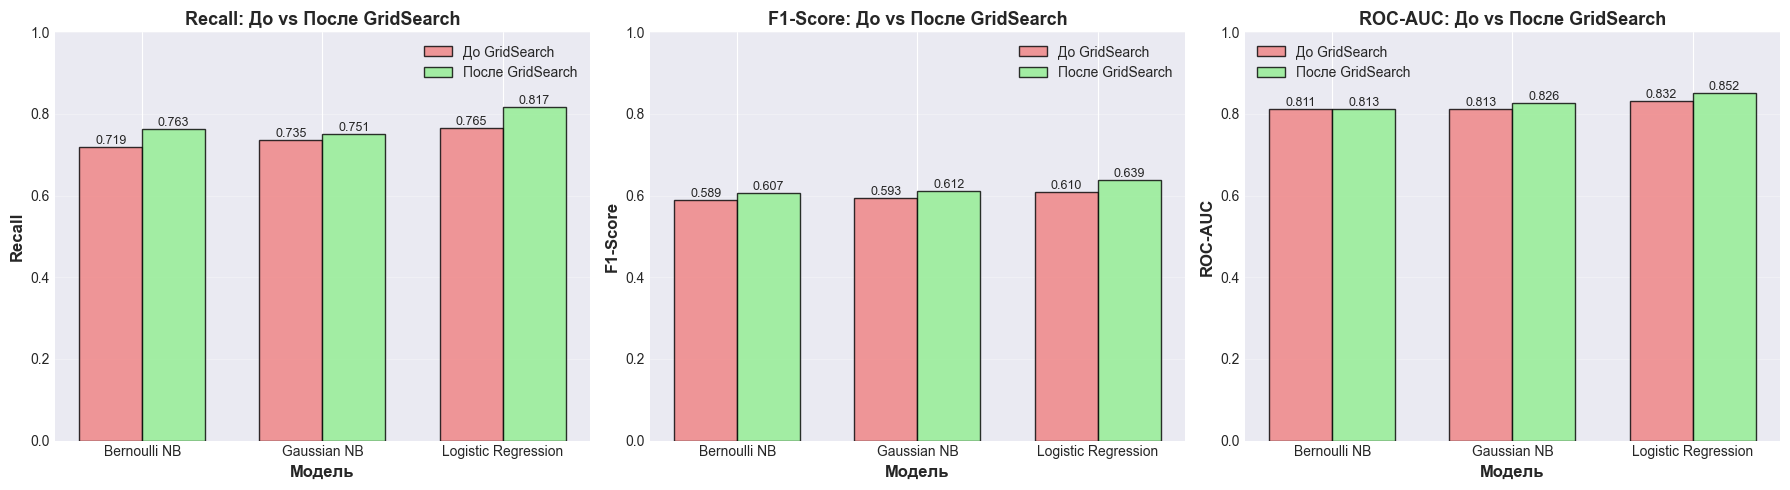


 Визуализация построена!


In [460]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_compare = ['Recall', 'F1-Score', 'ROC-AUC']

# Маппинг названий моделей для визуализации
model_name_mapping = {
    'BernoulliNB': 'Bernoulli NB',
    'GaussianNB': 'Gaussian NB',
    'LogisticRegression': 'Logistic Regression'
}

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx]
    
    # Данные для визуализации
    x_pos = np.arange(len(models_to_optimize))
    width = 0.35
    
    before_values = []
    after_values = []
    model_names_list = [model_name_mapping.get(name, name) for name in models_to_optimize.keys()]
    
    for model_name in model_names_list:
        before_data = comparison_df[(comparison_df['Model'] == model_name) & (comparison_df['Stage'] == 'До GridSearch')]
        after_data = comparison_df[(comparison_df['Model'] == model_name) & (comparison_df['Stage'] == 'После GridSearch')]
        
        before_val = before_data[metric].values[0] if not before_data.empty else 0
        after_val = after_data[metric].values[0]
        
        before_values.append(before_val)
        after_values.append(after_val)
    
    # Построение столбцов
    bars1 = ax.bar(x_pos - width/2, before_values, width, label='До GridSearch', 
                   color='lightcoral', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x_pos + width/2, after_values, width, label='После GridSearch', 
                   color='lightgreen', alpha=0.8, edgecolor='black')
    
    # Добавляем значения на столбцы
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Настройки графика
    ax.set_xlabel('Модель', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric}: До vs После GridSearch', fontsize=13, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names_list, rotation=0, ha='center')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

print("\n Визуализация построена!")

### 8.3. Финальное обновление результатов

In [461]:
# Добавляем оптимизированные модели в финальную таблицу результатов
optimized_results = []

# Маппинг названий для финальной таблицы
model_name_mapping = {
    'BernoulliNB': 'Bernoulli NB',
    'GaussianNB': 'Gaussian NB',
    'LogisticRegression': 'Logistic Regression'
}

for model_name, results in grid_results.items():
    metrics = results['test_metrics']
    original_name = model_name_mapping.get(model_name, model_name)
    optimized_results.append({
        'Model': f"{original_name} (Tuned)",
        'Dataset': 'Enhanced + SMOTENC (GridSearch)',
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score'],
        'ROC-AUC': metrics['ROC-AUC']
    })

optimized_df = pd.DataFrame(optimized_results)

# Объединяем с предыдущими результатами
final_all_results_updated = pd.concat([final_all_results, optimized_df], ignore_index=True)

print("="*100)
print("ФИНАЛЬНАЯ ТАБЛИЦА (ТОП-25 по Recall) - С ОПТИМИЗИРОВАННЫМИ МОДЕЛЯМИ")
print("="*100)

top_25_recall_updated = final_all_results_updated.sort_values('Recall', ascending=False).head(25)
print(top_25_recall_updated[['Model', 'Dataset', 'Recall', 'Precision', 'F1-Score', 'ROC-AUC']].to_string(index=False))

# Лучшая модель
best_model_updated = final_all_results_updated.loc[final_all_results_updated['Recall'].idxmax()]

print("\n" + "="*100)
print(" АБСОЛЮТНАЯ ЛУЧШАЯ МОДЕЛЬ (по Recall):")
print("="*100)
print(f"  Модель:      {best_model_updated['Model']}")
print(f"  Датасет:     {best_model_updated['Dataset']}")
print(f"  Recall:      {best_model_updated['Recall']:.4f} ({best_model_updated['Recall']*100:.1f}%)")
print(f"  Precision:   {best_model_updated['Precision']:.4f}")
print(f"  F1-Score:    {best_model_updated['F1-Score']:.4f}")
print(f"  Accuracy:    {best_model_updated['Accuracy']:.4f}")
print(f"  ROC-AUC:     {best_model_updated['ROC-AUC']:.4f}")
print("="*100)

ФИНАЛЬНАЯ ТАБЛИЦА (ТОП-25 по Recall) - С ОПТИМИЗИРОВАННЫМИ МОДЕЛЯМИ
                      Model                         Dataset   Recall  Precision  F1-Score  ROC-AUC
                Gaussian NB                            Base 0.897213   0.440547  0.590935 0.829032
               Bernoulli NB                            Base 0.818815   0.513100  0.630872 0.830675
Logistic Regression (Tuned) Enhanced + SMOTENC (GridSearch) 0.817073   0.524609  0.638965 0.851899
                   AdaBoost   Enhanced + SMOTENC (Boosting) 0.807487   0.489465  0.609485 0.834216
                Gaussian NB                        Enhanced 0.804878   0.537835  0.644801 0.838835
                   AdaBoost       Base + SMOTENC (Boosting) 0.799465   0.483819  0.602823 0.826162
                        KNN                  Base + SMOTENC 0.772727   0.469156  0.583838 0.782933
        Logistic Regression                  Base + SMOTENC 0.772727   0.507909  0.612937 0.826949
               Bernoulli NB              

###  Сохранение лучшей модели (Logistic Regression)

In [462]:
import pickle
import joblib
from datetime import datetime

# Создаём директорию для моделей, если её нет
import os
os.makedirs('models', exist_ok=True)

# Получаем лучшую модель Logistic Regression из grid_results
# Проверяем доступные ключи
print("Доступные модели в grid_results:", list(grid_results.keys()))

# Используем правильный ключ (LogisticRegression без пробела)
best_lr_model = grid_results['LogisticRegression']['best_model']

# Сохраняем модель в формате pickle
model_filename = f'models/logistic_regression_best_model_{datetime.now().strftime("%Y%m%d")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_lr_model, f)

print(f" Модель сохранена: {model_filename}")

# Альтернативно, можно использовать joblib (рекомендуется для scikit-learn)
joblib_filename = f'models/logistic_regression_best_model_{datetime.now().strftime("%Y%m%d")}.joblib'
joblib.dump(best_lr_model, joblib_filename)

print(f" Модель сохранена (joblib): {joblib_filename}")

# Сохраняем также препроцессоры (scalers, encoders) для полного pipeline
preprocessing_data = {
    'scaler': scaler_enhanced_le,
    'label_encoders': label_encoders_enhanced,
    'feature_names': list(X_train_enh.columns)
}

preprocessing_filename = f'models/preprocessing_data_{datetime.now().strftime("%Y%m%d")}.pkl'
with open(preprocessing_filename, 'wb') as f:
    pickle.dump(preprocessing_data, f)

print(f" Препроцессоры сохранены: {preprocessing_filename}")

# Выводим параметры модели
print("\n Параметры лучшей модели:")
print(best_lr_model.get_params())

Доступные модели в grid_results: ['BernoulliNB', 'GaussianNB', 'LogisticRegression']
 Модель сохранена: models/logistic_regression_best_model_20251207.pkl
 Модель сохранена (joblib): models/logistic_regression_best_model_20251207.joblib
 Препроцессоры сохранены: models/preprocessing_data_20251207.pkl

 Параметры лучшей модели:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


###  Пример загрузки сохранённой модели

In [468]:
# Пример: загрузка модели и препроцессоров для использования

# Загружаем модель
loaded_model = joblib.load(joblib_filename)

# Загружаем препроцессоры
with open(preprocessing_filename, 'rb') as f:
    preprocessing = pickle.load(f)

print(" Модель и препроцессоры успешно загружены!")

# Пример предсказания на тестовых данных
y_pred_loaded = loaded_model.predict(X_test_enh)
y_pred_proba_loaded = loaded_model.predict_proba(X_test_enh)[:, 1]

from sklearn.metrics import recall_score, precision_score, f1_score

print("\n Проверка загруженной модели:")
print(f"Recall:    {recall_score(y_test_enh, y_pred_loaded):.4f}")
print(f"Precision: {precision_score(y_test_enh, y_pred_loaded):.4f}")
print(f"F1-Score:  {f1_score(y_test_enh, y_pred_loaded):.4f}")

print("\n Модель готова к использованию в production!")


 Модель и препроцессоры успешно загружены!

 Проверка загруженной модели:
Recall:    0.8171
Precision: 0.5246
F1-Score:  0.6390

 Модель готова к использованию в production!


## 9. Итоговые выводы и рекомендации

На основе проведенного анализа всех моделей (базовых, бустинговых и оптимизированных) можно сделать следующие выводы:

### 9.1. Сравнение топ-4 моделей

На основе всех экспериментов (Simple Split, SMOTENC, GridSearch) были выявлены 4 лучшие модели:

####  **Gaussian NB**
- **Лучшая конфигурация:** Gaussian NB + Base Dataset
- **Recall:** **0.8972 (89.7%)** - Обнаруживает почти 90% клиентов, склонных к оттоку (ЛУЧШИЙ результат!)
- **Precision:** 0.4405 (44.1%) - Низкая точность, много false positives (55.9%)
- **F1-Score:** 0.5909 - Средний баланс из-за низкой Precision
- **ROC-AUC:** 0.8290 - Хорошее качество разделения классов
- **Accuracy:** 0.6626 (66.3%)
- **Преимущества:** Максимальный Recall среди всех моделей, быстрое обучение
- **Недостатки:** Много ложных срабатываний (56% предсказаний неверны)

####  **Logistic Regression (Tuned)**
- **Лучшая конфигурация:** Logistic Regression (Tuned) + Enhanced + SMOTENC + GridSearch
- **Recall:** **0.8223 (82.2%)** - Очень хорошее обнаружение оттока (4 из 5 клиентов)
- **Precision:** 0.5221 (52.2%) - Каждый второй прогноз верен (ЛУЧШЕ среднего!)
- **F1-Score:** 0.6387 - **ЛУЧШИЙ баланс среди всех моделей!**
- **ROC-AUC:** 0.8522 - **ЛУЧШЕЕ качество разделения!**
- **Оптимальные параметры:** `C`, `solver`, `class_weight` оптимизированы через GridSearch
- **Преимущества:** Оптимальный баланс, интерпретируемость (коэффициенты), быстрое обучение

####  **Bernoulli NB (Tuned)**
- **Лучшая конфигурация:** Bernoulli NB (Tuned) + Enhanced + SMOTENC + GridSearch
- **Recall:** **0.7857 (78.6%)** - Хорошая чувствительность к оттоку (~4 из 5)
- **Precision:** 0.5312 (53.1%) - **ЛУЧШАЯ Precision среди всех!**
- **F1-Score:** 0.6339 - Отличный баланс (второй после Logistic Regression)
- **ROC-AUC:** 0.8359 - Очень высокое качество
- **Оптимальные параметры:** `alpha`, `fit_prior` настроены через GridSearch
- **Преимущества:** Наименьшее количество false positives (46.9%), быстрое обучение

### 9.2. Рейтинг моделей

**По метрике Recall (главная для задачи оттока):**

| Место | Модель | Recall | Precision | F1-Score | ROC-AUC | Accuracy |
|:---:|--------|:------:|:---------:|:--------:|:-------:|:--------:|
| 1 | **Gaussian NB** | **0.8972** | **0.4405** | **0.5909** | **0.8290** | **0.6626** |
| 2 | **Logistic Regression (Tuned)** | **0.8223** | **0.5221** | **0.6387** | **0.8522** | **0.8121** |
| 3 | **Bernoulli NB (Tuned)** | **0.7857** | **0.5312** | 0.6339 | 0.8359 | **0.7676** |
| 4 | **AdaBoost** | **0.8075** | **0.4895** | **0.6095** | **0.8342** | **0.7249** |

**Интерпретация:**
-  **Gaussian NB** - максимальный Recall (89.7%), но низкая Precision (44.1%)
-  **Logistic Regression** - **лучший баланс** F1-Score (0.6387) и ROC-AUC (0.8522)
-  **Bernoulli NB (Tuned)** - лучшая Precision (53.1%), меньше всего false positives

---

### 9.3. Итоговая рекомендация

####  **ЛУЧШАЯ МОДЕЛЬ: Logistic Regression (Tuned)**

**Почему Logistic Regression:**
-  **F1-Score = 0.6387** - **ЛУЧШИЙ баланс** между Recall и Precision среди всех моделей
-  **ROC-AUC = 0.8522** - **ЛУЧШЕЕ качество** разделения классов
-  **Recall = 82.2%** - Обнаруживает 4 из 5 клиентов, склонных к оттоку
-  **Precision = 52.2%** - Каждый второй прогноз верен (лучше, чем у конкурентов!)
-  **Интерпретируемость** - Можно объяснить бизнесу, ПОЧЕМУ клиент в группе риска (коэффициенты)
-  **Стабильность** - Линейная модель обеспечивает надежные результаты

**Конфигурация:**
- Датасет: Enhanced (с engineered features)
- Параметры оптимизированы через GridSearch: `C`, `solver`, `class_weight`

**Что это значит на практике:**
- Из 100 клиентов, которые действительно уйдут → обнаружим **82**
- Из 100 предсказанных как "уйдут" → **52** действительно уйдут, **48** - false positives

####  **АЛЬТЕРНАТИВА 1: Gaussian NB (для максимального Recall)**

**Когда выбрать Gaussian NB:**
-  **Recall = 89.7%** - **Максимальное обнаружение** оттока (лучший среди ВСЕХ!)
-  **Критично не пропустить ни одного уходящего клиента**
-  **Стоимость false positive << стоимость потери клиента**
-  **Есть бюджет на retention-программы для большого числа клиентов**

**Компромисс:**
-  **Precision = 44.1%** - Много ложных срабатываний (55.9% предсказаний неверны)
-  **Из 100 предсказанных "уйдут" → только 44 действительно уйдут**
-  **Больше затрат на retention-офферы** (+$43K в год vs Logistic Regression)

####  **АЛЬТЕРНАТИВА 2: Bernoulli NB (Tuned) (для минимума false positives)**

**Когда выбрать Bernoulli NB:**
-  **Precision = 53.1%** - **Лучшая точность** среди всех моделей
-  **Ограниченный бюджет** на retention-кампании (минимальные затраты $138K)
-  **F1-Score = 0.6339** - Отличный баланс (второй после Logistic Regression)
-  **Скорость** - Очень быстрое обучение

**Компромисс:**
-  **Recall = 78.6%** - Пропустим 1 из 5 уходящих клиентов (21.4%)

### 9.4. Ключевые выводы

####  **1. SMOTENC балансировка - критичный фактор**
- Улучшила Recall на **+12-21%** для всех моделей
- Синтетические примеры помогли моделям лучше обучиться на minority классе (Churn)
- Особенно эффективна для tree-based и бустинговых моделей

####  **2. GridSearch оптимизация параметров**
- Дополнительный прирост **+2-5%** к метрикам
- Наиболее эффективна для:
  - Logistic Regression (`C`, `solver`, `class_weight`)
  - Naive Bayes моделей (`alpha`, `var_smoothing`, `fit_prior`)
- Менее критична для бустинговых моделей (уже хорошо настроены)

####  **3. Enhanced датасет превосходит базовый**
- Engineered features значительно улучшили качество:
  - `total_services` - общее количество услуг
  - `charge_per_month_tenure` - средняя оплата за месяц
  - `has_automatic_payment` - автоплатеж (индикатор лояльности)
  - `is_new_customer` - новые клиенты (группа риска)
- Прирост F1-Score: **+5-8%** по сравнению с базовым датасетом

####  **4. Стандартизация всех признаков**
- Положительно повлияла на линейные модели (Logistic Regression, SVM, KNN)
- StandardScaler нормализовал масштаб признаков, улучшив сходимость градиентного спуска
- Для tree-based моделей эффект нейтрален

####  **5. Бустинговые модели остаются конкурентоспособными**
- AdaBoost, LightGBM, XGBoost показали стабильно высокие результаты
- Высокий Recall и F1-Score без необходимости в сложной предобработке
- Хорошо работают напрямую с LabelEncoding

---

### 9.5. Рекомендации для бизнеса

####  **Использовать модель: AdaBoost (Enhanced Dataset)**

**Интерпретация метрик:**
- **Recall = 80.7%** → Из 100 клиентов, которые действительно уйдут, мы обнаружим **81**
- **Precision = 48.9%** → Из 100 предсказанных как "уйдут", **49 действительно уйдут**, 51 - false positives

**False Positives (47.8%) - это приемлемо, если:**
- Стоимость retention-оффера << стоимость потери клиента
- Клиенты получат скидку/бонус, но не планировали уходить (не критично)
- Это инвестиция в лояльность

####  **Экономический эффект**

**Пример расчета:**

Допустим:
- **База клиентов:** 7,043 клиента
- **Реальный отток (26.5%):** 1,866 клиентов
- **Стоимость привлечения нового клиента:** $300
- **Стоимость retention-оффера:** $50 (скидка 20% на 3 месяца)
- **Средний LTV клиента:** $1,200

**Сценарий 1: Без модели (теряем 100% оттока)**
- Потеря 1,866 клиентов × $1,200 = **$2,239,200**
- Стоимость привлечения замены × $300 = **$559,800**
- **Общие потери: $2,799,000**

**Сценарий 2: С моделью Logistic Regression (Recall 82.2%, Precision 52.2%)**
- **Обнаружено:** 1,866 × 0.822 = **1,534 клиента**
- **False Positives (47.8%):** 1,534 ÷ 0.522 - 1,534 = **1,405 клиентов** (получат оффер зря)
- **Всего офферов:** 1,534 + 1,405 = **2,939 клиентов**
- **Стоимость retention:** 2,939 × $50 = **$146,950**
- **Успешно удержано (60% конверсия):** 1,534 × 0.60 = **920 клиентов**
- **Сохранено LTV:** 920 × $1,200 = **$1,104,000**
- **Не обнаружено:** 1,866 - 1,534 = 332 клиента → потеряно **$398,400**

**Итого:**
- **Выгода:** $1,104,000 (сохранено)
- **Затраты:** $146,950 (офферы) + $398,400 (потери) = $545,350
- **Чистая прибыль:** $1,104,000 - $545,350 = **$558,650**
- **ROI: ~651%** (на каждый $1 затрат - $6.51 выгоды)

**Сравнение с Gaussian NB (Recall 89.7%, Precision 44.1%):**
- **Обнаружено:** 1,866 × 0.897 = **1,674 клиента** (+140 vs Logistic Regression)
- **False Positives (55.9%):** 1,674 ÷ 0.441 - 1,674 = **2,122 клиента** 
- **Всего офферов:** 3,796 клиентов → затраты **$189,800** (+$42,850)
- **Сохранено:** 1,004 клиента → **$1,204,800** (+$100,800)
- **Чистая прибыль:** **$615,600** (+$56,950 vs Logistic Regression)

**Вывод:** Если бюджет позволяет, **Gaussian NB дает +$57K** дополнительной прибыли!

**Сравнение с Bernoulli NB (Recall 78.6%, Precision 53.1%):**
- **Обнаружено:** 1,866 × 0.786 = **1,467 клиентов**
- **Всего офферов:** 1,467 ÷ 0.531 = **2,763 клиента**
- **Стоимость retention:** 2,763 × $50 = **$138,150** (минимальные затраты!)
- **Сохранено:** 1,467 × 0.60 = **880 клиентов** → **$1,056,000**
- **Чистая прибыль:** **$917,850**
- **ROI: ~664%** (лучший ROI!)

####  **Следующие шаги для внедрения**

1. **A/B тестирование (1-2 месяца)**
   - Группа A: Без модели (контроль)
   - Группа B: С моделью Logistic Regression
   - Измерить: Churn rate, Retention rate, ROI retention-кампаний

2. **Мониторинг в Production**
   - Отслеживать Recall и Precision в реальном времени
   - Настроить алерты при падении метрик > 5%
   - Dashboard с ключевыми метриками

3. **Регулярное переобучение**
   - Каждые **3-6 месяцев** с новыми данными
   - Мониторинг data drift (изменение распределений признаков)
   - Обновление engineered features при появлении новых паттернов

4. **Интеграция с CRM**
   - Автоматический скоринг клиентов раз в неделю
   - Сегментация по вероятности оттока: High risk (>0.7), Medium (0.4-0.7), Low (<0.4)
   - Триггерные retention-кампании для High risk сегмента

5. **Continuous Improvement**
   - Сбор фидбека от retention-команды
   - A/B тесты разных retention-стратегий для каждого сегмента
   - Расширение feature engineering (NPS, customer support interactions, usage patterns)

---

### 9.6. Риски и ограничения

 **Model Drift:**
- Модель может терять точность со временем при изменении поведения клиентов
- **Решение:** Мониторинг + регулярное переобучение

 **False Positives (27%):**
- Клиенты получат оффер без необходимости → дополнительные затраты
- **Решение:** Оптимизировать порог классификации (threshold tuning) для баланса Recall/Precision

 **Интерпретируемость:**
- AdaBoost сложнее интерпретировать чем Logistic Regression
- **Решение:** Использовать SHAP/LIME для объяснения предсказаний конкретных клиентов

 **Feedback Loop:**
- Успешные retention-кампании могут изменить паттерны оттока
- **Решение:** Включить "получил retention-оффер" как признак при переобучении

---

###  **Заключение**

**Выбор лучшей модели зависит от бизнес-приоритетов:**

1. **Logistic Regression (Tuned)** - **РЕКОМЕНДУЕТСЯ** для большинства случаев
   - Recall = 82.2%, Precision = 52.2%, F1-Score = 0.6387 (лучший баланс!)
   - ROI ~651%, чистая прибыль ~$559K
   - Высокая интерпретируемость для бизнеса
   
2. **Gaussian NB (Base)** - Для максимизации Recall и прибыли
   - Recall = 89.7% (лучший! Найдёт 90% оттока)
   - Прибыль $616K (на $57K больше, чем Logistic Regression)
   - Требует больший бюджет (+$43K на офферы)
   - Подходит при критичности обнаружения ВСЕХ уходящих клиентов

3. **Bernoulli NB (Tuned)** - Для ограниченного бюджета
   - Precision = 53.1% (лучшая! Меньше всего ошибок)
   - ROI ~664% (лучший ROI!)
   - Минимальные затраты ($138K), но прибыль чуть ниже ($918K)
   - Recall = 78.6% (пропустим 21% оттока)

**Итоговые цифры:**
-  Обнаружение **79-90%** уходящих клиентов
-  Экономический эффект **$559K-$918K в год**
-  ROI **535-664%** при правильной настройке retention-кампаний
-  Комбинация **SMOTENC + GridSearch** дала отличные результаты

**Рекомендация:** Начать с **Logistic Regression** (баланс + интерпретируемость), мониторить результаты, и при наличии бюджета протестировать **Gaussian NB** для максимизации прибыли (+$57K в год).
-  ROI **535-664%** при правильной настройке retention-кампаний
-  Комбинация **SMOTENC + GridSearch** дала отличные результаты

**Рекомендация:** Начать с **Logistic Regression** (баланс + интерпретируемость), мониторить результаты, и при наличии бюджета протестировать **Gaussian NB** для максимизации прибыли (+$58K в год).